In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
import pylab as pl
from IPython import display


from sklearn.decomposition import RandomizedPCA

In [395]:
# slow, O(n), about 1 sec per call
# also doesn't use obj_func
def line_search(point, grad, obj_func):
    """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """
    
    dx = 1e-3

    cpt = np.copy(point)
    prev_norm = np.linalg.norm(cpt,'nuc')
    
    while np.linalg.norm(cpt - grad * dx,'nuc') < prev_norm:
        prev_norm = np.linalg.norm(cpt,'nuc')
        cpt = cpt - grad * dx
    
    #cpt = cpt - grad * dx
        
    return cpt

In [13]:
# faster version, O(log(n)), about 3 ms per call; almost 1000 times faster!
# also allows faster precision (threshold colud be made very small without significan performance overheads)
def line_search(point, grad, obj_func, s = 4, threshold = 1e-10):
    """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """
    
    # find local cusp, note: this can be reused
    choice = point - grad * s
    while obj_func(choice) > obj_func(point):
        s = s / 2
        choice = point - grad * s
        
    #print("Initial s: " + str(s))
    initial_s = s
    
    while True:
        left = choice + grad * s/2
        right = point - grad * s/2

        s = s / 2
        if obj_func(left) < obj_func(right):
            choice = left
        else:
            choice = right
            
        if np.abs(obj_func(left) - obj_func(right)) < threshold:
            break
    #print("Final s: " + str(s))
    
    #while np.linalg.norm(cpt - grad * dx,'nuc') < prev_norm:
    #    prev_norm = np.linalg.norm(cpt,'nuc')
    #    cpt = cpt - grad * dx
    
    #cpt = cpt - grad * dx
        
    return (choice, initial_s, s)

## Generate solution and mask

In [11]:
# Define a matrix, mask and noise
p = 0.75
rank = 1

n = 10

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])

It looks like multicoordinate subgradient descent actually has better performance than subgradient descent because it's less time consuming to compute the subgradient for the first one and that also doesn't seem to affect the descent speed too much.

## Subgradient descent

In [410]:
%%time

def obj_func(m):
    return np.linalg.norm(m,'nuc') 

def comp_grad(m,boolMask):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    grad = np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)
                
    return grad

starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()

for i in range(10):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    #if i % 1 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'))
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    grad = comp_grad(current_point,boolMask)
    
    #current_point = current_point - grad * step_size
    current_point = line_search(current_point, grad, obj_func)
    
    #pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
    #       interpolation='nearest', vmin=0, vmax=1)
    #display.clear_output(wait=False)
    #display.display(pl.gcf())
    
#plt.plot(norms)
#plt.plot(distances)

0 70.42699539678267 0.0 15.69879110196073


ValueError: Invalid norm order for vectors.

## Coordinate subgradient descent

In [334]:
def obj_func(m):
    return np.linalg.norm(m,'nuc') 

def comp_grad(m,boolMask):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    grad = np.zeros([n,n])
    
    total_choices = np.sum(1 - mask)
    index_to_compute = np.random.randint(total_choices)

    # Find what position in the matrix this corresponds to
    current_index = 0
    iterator = 0
    i = 0
    j = 0
    while current_index != index_to_compute:
        i = iterator % n
        j = iterator // n
        if boolMask[i,j]:
            current_index = current_index + 1
        iterator = iterator + 1
        

                
    diff = np.zeros([n,n])
    diff[i,j] = epsilon
    grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)
                
    return grad

# Define a matrix, mask and noise
p = 0.75
rank = 1

n = 40

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])
#mask = np.ones([n,n])
#mask[0,0] = 0

starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()

for i in range(10):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    #if i % 1 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'))
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    %timeit grad = comp_grad(current_point,boolMask)
    
    #current_point = current_point - grad * step_size
    current_point = line_search(current_point, grad)
    
    #pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
    #       interpolation='nearest', vmin=0, vmax=1)
    #display.clear_output(wait=False)
    #display.display(pl.gcf())
    
#plt.plot(norms)
#plt.plot(distances)

0 104.92608556404414 0.0 21.531825001602652
3.81 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1 104.92608556404414 0.0 21.531825001602652
3.31 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2 104.92608556404414 0.0 21.531825001602652


## Multi-coordinate subgradient descent

Only evaluates the gradient for a portion of coordinates

In [18]:
def obj_func(m):
    return np.linalg.norm(m,'nuc') 

def comp_grad(m, boolMask, portion):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    grad = np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)
                
    return grad

starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    if i % 1000 == 0:
        print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    grad = comp_grad(current_point,boolMask, portion)
    current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1000 15.30281013024909 -0.0002750426056099542 3.4512386322810777 0.001953125 0.0009765625 1.1
2000 15.040227159908307 -0.00025032225463128555 2.944913838744871 0.001953125 0.0009765625 1.1
3000 14.801813622219555 -0.00022672932807132895 2.462454848985746 0.001953125 0.0009765625 1.1
4000 14.586367285211598 -0.00020440776694563567 2.003824142132609 0.001953125 0.0009765625 1.1
5000 14.392559072052075 -0.0001834669410705203 1.5688357200879648 0.001953125 0.0009765625 1.1
6000 14.21896850101069 -0.00016398028174435808 1.1571630934602746 0.001953125 0.0009765625 1.1
7000 14.064119413976018 -0.00014598603360660434 0.7683509548142673 0.001953125 0.0009765625 1.1
8000 13.926514023767268 -0.00012948977749083213 0.4018297069869898 0.001953125 0.0009765625 1.1
9000 13.804664666756386 -0.00011446006913651274 0.056933690305429246 0.001953125 0.0009765625 1.1


Text(0,0.5,'Frob distance to actual solution')

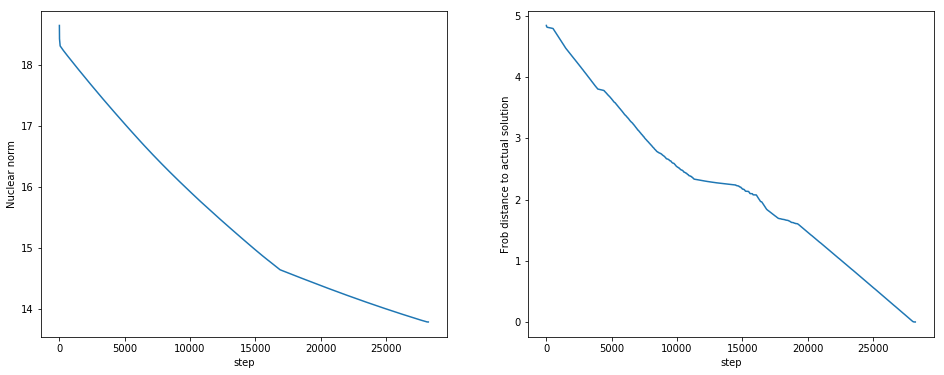

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

Text(0,0.5,'Frob distance to actual solution')

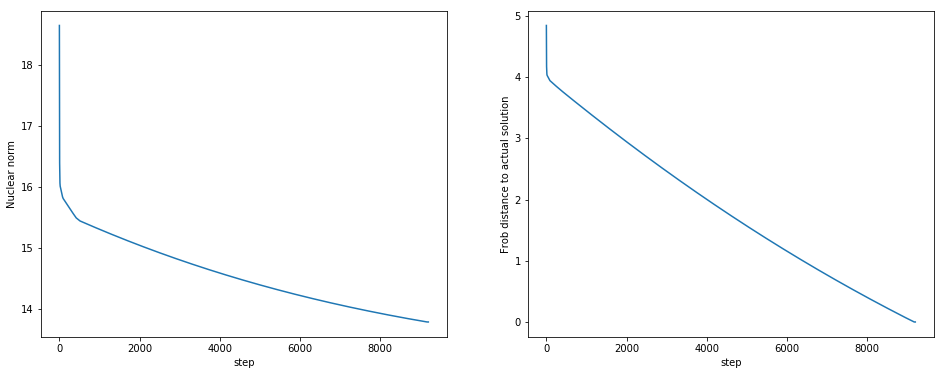

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

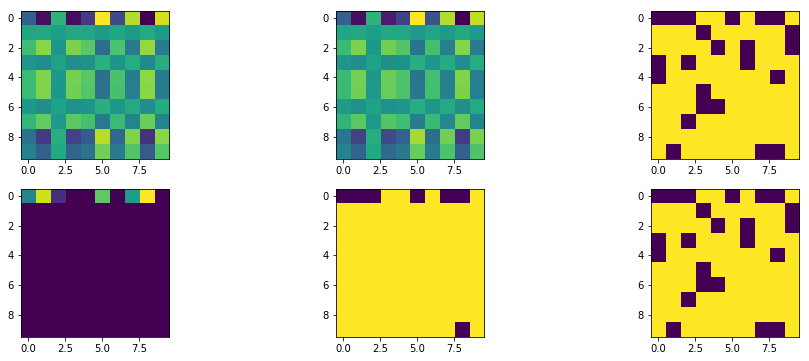

In [450]:
fig, ((ax1, ax2, ax3), (ax21, ax22, ax23)) = plt.subplots(2,3, figsize=(16,6))

ax1.imshow(current_point)
ax2.imshow(original)
ax3.imshow(current_point == original)

ax21.imshow(np.abs(current_point - original))
ax22.imshow(np.abs(current_point - original) < 1e-3)
ax23.imshow(mask)

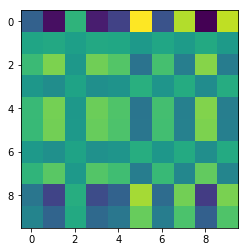

In [438]:
plt.imshow(original)

## Steepest descent

See https://docs.google.com/viewer?url=https://github.com/RoyiAvital/Projects/raw/master/Optimization/SteepestDescent/SteepestDescentNorms.pdf

In [16]:
def obj_func(m):
    return np.linalg.norm(m,'nuc') 

def comp_grad(m, boolMask, portion):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    grad = np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)
                
    return grad

starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    if i % 1000 == 0:
        print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    grad = comp_grad(current_point,boolMask, portion)
    
    # get maximum value in magnitude
    x,y = np.unravel_index(np.abs(grad).argmax(), grad.shape)
    descent = np.zeros([n,n])
    descent[x,y] = np.sign(grad[x,y])
    
    current_point, initial_s, s = line_search(current_point, descent, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1000 18.04137059771387 -0.0002671588651352863 4.634219136243792 0.0009765625 0.00048828125 1.1
2000 17.77832776685818 -0.0002596757970394492 4.335462944156464 0.0009765625 0.00048828125 1.1
3000 17.521854278468304 -0.00025314169443291235 4.064076186062059 0.0009765625 0.00048828125 1.1
4000 17.272353460826857 -0.00024750682785068534 3.80340495171888 0.0009765625 0.00048828125 1.1
5000 17.02883425841576 -0.00024301415766458945 3.6441084484385544 0.0009765625 0.00048828125 1.1
6000 16.79024452633503 -0.00023567473536445505 3.3901787038607787 0.0009765625 0.00048828125 1.1
7000 16.559481416533853 -0.0002262688470686669 3.137412881770501 0.0009765625 0.00048828125 1.1
8000 16.338640116170932 -0.00024782073412765726 2.894792744250752 0.0009765625 0.00048828125 1.1
9000 16.126384690044198 -0.00020264855640661494 2.710838101284532 0.0009765625 0.00048828125 1.1
10000 15.920561975504581 -0.00020450062553400983 2.5367112579476903 0.0009765625 

## Newton method

Only computed diagonal entries of the Hessian

So far this is the fastest here

In [40]:
def obj_func(m):
    return np.linalg.norm(m,'nuc') 

def comp_grad(m, boolMask, obj_func):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))
                
    return grad

def comp_hessian(m, boolMask, of):
    """ Computes hessian (only diagonal) """
    epsilon = 1e-3
    
    hessian = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                row = []
                
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)
                
    return hessian


starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    #if i % 1000 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    descent = np.dot(np.linalg.inv(np.diag(comp_hessian(current_point,boolMask,obj_func))),
       comp_grad(current_point,boolMask,obj_func))
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point - 0.1*descent_matrix
    
    #current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1 17.21917739337033 -1.4210760601196064 3.691982120267178 4 4 1.1
2 16.490451083583743 -0.7287263097865875 2.9022034494147384 4 4 1.1
3 16.04592304209043 -0.4445280414933137 2.3394781418181636 4 4 1.1
4 15.774070694945943 -0.2718523471444865 1.95724564312863 4 4 1.1
5 15.563889900562947 -0.21018079438299608 1.6714876245826873 4 4 1.1
6 15.359573721476782 -0.20431617908616495 1.4384803687835266 4 4 1.1
7 15.200623626813481 -0.15895009466330023 1.255920347164639 4 4 1.1
8 15.05882991759602 -0.14179370921746148 1.1157468723580304 4 4 1.1
9 14.951924325656234 -0.10690559193978544 1.0087433150659666 4 4 1.1
10 14.880376304606134 -0.07154802105010027 0.9131698759002072 4 4 1.1
11 14.822725636475171 -0.05765066813096276 0.8381291558691497 4 4 1.1
12 14.755583412827578 -0.06714222364759337 0.7673251148582725 4 4 1.1
13 14.699110715574331 -0.05647269725324655 0.715164449609399 4 4 1.1
14 14.651159138898299 -0.04795157667603256 0.66735730648501

115 13.881686010835043 -0.0006788867008911126 0.08056005256458122 4 4 1.1
116 13.881019539942717 -0.0006664708923267426 0.08011392266446762 4 4 1.1
117 13.88036478520523 -0.0006547547374857743 0.07967449655694962 4 4 1.1
118 13.879721137457205 -0.000643647748026055 0.07924141697367307 4 4 1.1
119 13.879088065745913 -0.0006330717112916773 0.07881437626215533 4 4 1.1
120 13.878465106092996 -0.0006229596529170323 0.07839310923279214 4 4 1.1
121 13.877851851448193 -0.0006132546448025522 0.07797738678230785 4 4 1.1
122 13.877247957228887 -0.0006038942193065111 0.0775670272892743 4 4 1.1
123 13.876653133107087 -0.0005948241217996753 0.07716189119455735 4 4 1.1
124 13.876067094663776 -0.0005860384433109544 0.07676182766238122 4 4 1.1
125 13.875489584696556 -0.0005775099672202799 0.07636670290558228 4 4 1.1
126 13.874920427852517 -0.0005691568440386874 0.07597645666035341 4 4 1.1
127 13.874359449755808 -0.000560978096709519 0.07559102325268345 4 4 1.1
128 13.873806448651296 -0.0005530011045120

227 13.839362935432455 -0.0002550243880268255 0.0504302176010984 4 4 1.1
228 13.839108727161358 -0.0002542082710963456 0.050241385967553585 4 4 1.1
229 13.838855322776993 -0.0002534043843649414 0.05005307601673078 4 4 1.1
230 13.838602710082828 -0.00025261269416532173 0.04986528007736433 4 4 1.1
231 13.838350877200012 -0.0002518328828156058 0.049677990747122085 4 4 1.1
232 13.83809981549578 -0.0002510617042315033 0.049491201886405295 4 4 1.1
233 13.83784951830207 -0.0002502971937108356 0.049304908028883064 4 4 1.1
234 13.837599973615374 -0.0002495446866959128 0.049119101765175366 4 4 1.1
235 13.837351170102423 -0.0002488035129513122 0.04893377610121296 4 4 1.1
236 13.837103097018119 -0.000248073084303968 0.048748924403623196 4 4 1.1
237 13.836855744143712 -0.0002473528744069142 0.04856454035832833 4 4 1.1
238 13.83660910892498 -0.00024663521873158345 0.04838061793884025 4 4 1.1
239 13.836363242515779 -0.00024586640920176706 0.04819714652958384 4 4 1.1
240 13.836118000212986 -0.00024524

337 13.815310074669744 -0.00016824236483081734 0.03203471336133875 4 4 1.1
338 13.815143589686784 -0.00016648498296056857 0.03189543903248994 4 4 1.1
339 13.8149788911731 -0.0001646985136840584 0.03175704442150313 4 4 1.1
340 13.814816006152068 -0.00016288502103201097 0.03161954244290153 4 4 1.1
341 13.814654959297169 -0.00016104685489892745 0.031482945074089747 4 4 1.1
342 13.814495772537365 -0.00015918675980408636 0.03134726312481706 4 4 1.1
343 13.814338465029701 -0.00015730750766351775 0.03121250636040721 4 4 1.1
344 13.81418305279002 -0.00015541223968185136 0.031078683279542663 4 4 1.1
345 13.814029548463175 -0.0001535043268443559 0.030945801015334715 4 4 1.1
346 13.813877961121348 -0.0001515873418274083 0.030813865246480353 4 4 1.1
347 13.813728298958564 -0.00014966216278367028 0.030682883568575934 4 4 1.1
348 13.813580564865104 -0.00014773409345991695 0.03055286022457763 4 4 1.1
349 13.813434756440543 -0.00014580842456091148 0.030423796193467433 4 4 1.1
350 13.813290867274464 -0

450 13.803516416914238 -8.296550759645527e-05 0.02006410191562975 4 4 1.1
451 13.803433526732977 -8.289018126106384e-05 0.01997182844469231 4 4 1.1
452 13.803350710767178 -8.281596579884365e-05 0.019879630633563523 4 4 1.1
453 13.80326796796764 -8.274279953823793e-05 0.01978750782071397 4 4 1.1
454 13.803185297344 -8.26706236409791e-05 0.01969545938435171 4 4 1.1
455 13.803102697961844 -8.259938215537943e-05 0.019603484740690933 4 4 1.1
456 13.803020168940108 -8.252902173566667e-05 0.019511583342304028 4 4 1.1
457 13.80293770944849 -8.245949161889143e-05 0.019419754676532838 4 4 1.1
458 13.802855318705072 -8.23907434170934e-05 0.019327998263976978 4 4 1.1
459 13.802772995974019 -8.232273105335253e-05 0.01923631365703842 4 4 1.1
460 13.802690740563376 -8.225541064277309e-05 0.01914470043853952 4 4 1.1
461 13.802608551823008 -8.218874036813872e-05 0.019053158220398592 4 4 1.1
462 13.802526429142608 -8.212268039997639e-05 0.01896168664236505 4 4 1.1
463 13.802444371949848 -8.2057192759776

563 13.794556942508335 -7.536901569515919e-05 0.010093498634509417 4 4 1.1
564 13.794481661575515 -7.528093281905512e-05 0.010009926265846625 4 4 1.1
565 13.794406469590625 -7.519198489092105e-05 0.009926458307938375 4 4 1.1
566 13.794331367438852 -7.510215177219948e-05 0.009843095802660176 4 4 1.1
567 13.794256356026038 -7.501141281451851e-05 0.00975983981617484 4 4 1.1
568 13.794181436279183 -7.491974685436276e-05 0.009676691439565106 4 4 1.1
569 13.794106609147015 -7.482713216866443e-05 0.00959365178948961 4 4 1.1
570 13.794031875600494 -7.473354652098863e-05 0.00951072200885466 4 4 1.1
571 13.793957236633426 -7.463896706738637e-05 0.009427903267514155 4 4 1.1
572 13.793882693263056 -7.454337037060554e-05 0.009345196762992147 4 4 1.1
573 13.793808246530674 -7.444673238232724e-05 0.009262603721221301 4 4 1.1
574 13.793733897502221 -7.43490284520476e-05 0.009180125397312807 4 4 1.1
575 13.793659647268974 -7.425023324714175e-05 0.009097763076350414 4 4 1.1
576 13.793585496948241 -7.415

673 13.787249978456158 -4.917532288750692e-05 0.002054231030913903 4 4 1.1
674 13.787201423616258 -4.855483989985032e-05 0.0020027122492501906 4 4 1.1
675 13.787153502507296 -4.792110896190138e-05 0.0019519788029349473 4 4 1.1
676 13.787106228394949 -4.72741123473952e-05 0.0019020484726833915 4 4 1.1
677 13.78705961452578 -4.661386916815502e-05 0.0018529390897213693 4 4 1.1
678 13.78701367408699 -4.5940438790026406e-05 0.0018046684835351533 4 4 1.1
679 13.78696842016255 -4.525392444065801e-05 0.0017572544240576297 4 4 1.1
680 13.786923865685969 -4.455447658102685e-05 0.0017107145581243815 4 4 1.1
681 13.78688002338962 -4.3842296349794196e-05 0.001665066340077264 4 4 1.1
682 13.786836905750706 -4.311763891351461e-05 0.0016203269564651803 4 4 1.1
683 13.786794524934177 -4.2380816529075105e-05 0.0015765132448725637 4 4 1.1
684 13.786752892732753 -4.163220142316959e-05 0.0015336416069952534 4 4 1.1
685 13.786712020504508 -4.087222824544767e-05 0.0014917279161890324 4 4 1.1
686 13.786671919

782 13.785498709179961 -7.565566484402098e-07 0.0005396218324616478 4 4 1.1
783 13.78549798901991 -7.201600507045214e-07 0.0005395096205460661 4 4 1.1
784 13.785497303478515 -6.855413960948908e-07 0.0005394035109409251 4 4 1.1
785 13.785496650862925 -6.526155900132835e-07 0.0005393031171164657 4 4 1.1
786 13.785496029561722 -6.213012024858244e-07 0.000539208080231425 4 4 1.1
787 13.785495438203764 -5.913579581573458e-07 0.0005391181029881549 4 4 1.1
788 13.78549487534193 -5.628618335862257e-07 0.0005390328773293994 4 4 1.1
789 13.785494339576282 -5.357656487348095e-07 0.0005389521116929444 4 4 1.1
790 13.7854938295752 -5.100010813663403e-07 0.0005388755348963472 4 4 1.1
791 13.785493344072307 -4.855028929995342e-07 0.0005388028945918762 4 4 1.1
792 13.785492881863524 -4.6220878324731984e-07 0.0005387339558388847 4 4 1.1
793 13.78549244180416 -4.4005936494784237e-07 0.000538668499794442 4 4 1.1
794 13.785492022806164 -4.189979954105638e-07 0.0005386063225018476 4 4 1.1
795 13.7854916238

892 13.78548356323439 -4.249361751362812e-09 0.0005373020353446203 4 4 1.1
893 13.785483559174086 -4.060304092945444e-09 0.0005373011544934295 4 4 1.1
894 13.785483555294364 -3.879721433008854e-09 0.0005373003090936015 4 4 1.1
895 13.785483551587154 -3.7072105385504983e-09 0.000537299497726526 4 4 1.1
896 13.785483548044741 -3.542412585488819e-09 0.000537298719028826 4 4 1.1
897 13.785483544659778 -3.3849634206717383e-09 0.0005372979716918041 4 4 1.1
898 13.785483541425194 -3.2345841560754707e-09 0.0005372972544593624 4 4 1.1
899 13.785483538334299 -3.0908946513363844e-09 0.0005372965661257355 4 4 1.1
900 13.78548353538066 -2.953639111069606e-09 0.0005372959055330551 4 4 1.1
901 13.785483532558162 -2.822497791044043e-09 0.0005372952715692143 4 4 1.1
902 13.78548352986093 -2.697232659443216e-09 0.0005372946631670842 4 4 1.1
903 13.785483527283407 -2.577522195679194e-09 0.000537294079301165 4 4 1.1
904 13.78548352482022 -2.4631869877111967e-09 0.0005372935189879146 4 4 1.1
905 13.7854835

1000 13.785483472213567 -3.305800078123866e-11 0.0005372805084775419 4 4 1.1
1001 13.78548347218195 -3.161737538448506e-11 0.0005372804986147713 4 4 1.1
1002 13.785483472151709 -3.0240698833949864e-11 0.0005372804891577388 4 4 1.1
1003 13.785483472122786 -2.8922642059114878e-11 0.0005372804800895982 4 4 1.1
1004 13.785483472095114 -2.7672086844177102e-11 0.0005372804713947943 4 4 1.1
1005 13.785483472068655 -2.645883512286673e-11 0.0005372804630580916 4 4 1.1
1006 13.78548347204334 -2.531486131829297e-11 0.0005372804550651632 4 4 1.1
1007 13.785483472019127 -2.4213520077864814e-11 0.0005372804474009449 4 4 1.1
1008 13.785483471995965 -2.3161916828939866e-11 0.0005372804400525297 4 4 1.1
1009 13.785483471973807 -2.2158275214678724e-11 0.0005372804330068088 4 4 1.1
1010 13.78548347195262 -2.1186608023526787e-11 0.0005372804262505012 4 4 1.1
1011 13.785483471932347 -2.027356060807506e-11 0.0005372804197723793 4 4 1.1
1012 13.785483471912954 -1.9392487615732534e-11 0.0005372804135614676 4 

1108 13.785483471490615 -2.8066438062523957e-13 0.0005372802718252499 4 4 1.1
1109 13.785483471490341 -2.7355895326763857e-13 0.0005372802717225819 4 4 1.1
1110 13.78548347149009 -2.504663143554353e-13 0.0005372802716232754 4 4 1.1
1111 13.785483471489847 -2.433608869978343e-13 0.0005372802715282751 4 4 1.1
1112 13.785483471489604 -2.433608869978343e-13 0.000537280271437111 4 4 1.1
1113 13.785483471489385 -2.184918912462308e-13 0.0005372802713497422 4 4 1.1
1114 13.785483471489162 -2.2382096176443156e-13 0.0005372802712661011 4 4 1.1
1115 13.785483471488961 -2.007283228522283e-13 0.0005372802711859037 4 4 1.1
1116 13.785483471488758 -2.0250467969162855e-13 0.000537280271109023 4 4 1.1
1117 13.785483471488565 -1.936228954946273e-13 0.0005372802710353883 4 4 1.1
1118 13.785483471488389 -1.758593271006248e-13 0.0005372802709646534 4 4 1.1
1119 13.78548347148821 -1.794120407794253e-13 0.0005372802708969259 4 4 1.1
1120 13.785483471488048 -1.616484723854228e-13 0.0005372802708320959 4 4 1.1

Text(0,0.5,'Frob distance to actual solution')

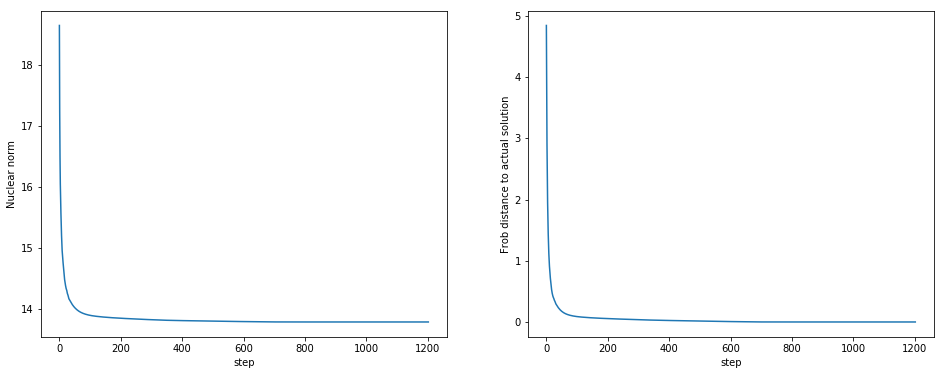

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

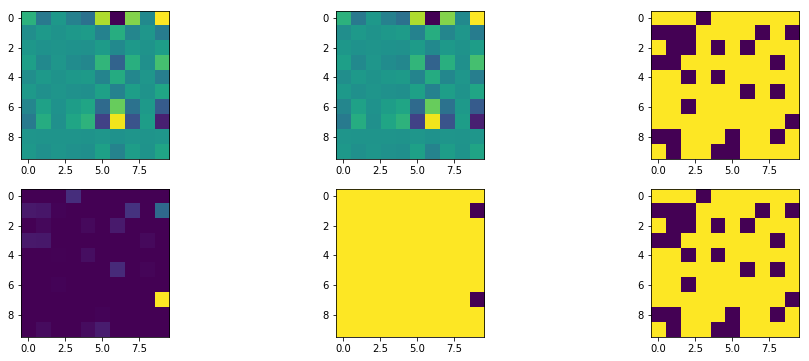

In [44]:
fig, ((ax1, ax2, ax3), (ax21, ax22, ax23)) = plt.subplots(2,3, figsize=(16,6))

ax1.imshow(current_point)
ax2.imshow(original)
ax3.imshow(current_point == original)

ax21.imshow(np.abs(current_point - original))
ax22.imshow(np.abs(current_point - original) < 1e-4)
ax23.imshow(mask)

## Now let's play with different objective functions

Minimize only smallest singular values

For 10 x 10 matrix, ignoring first singular value actully gives better performance.
Ignoring more singualar values makes performace worse.
It would be interesting to see how this scales to larger n.

In [76]:
def obj_func(m):
    svd = np.linalg.svd(m, compute_uv=False)
    
    return np.sum(svd[1:]) 

def comp_grad(m, boolMask, obj_func):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))
                
    return grad

def comp_hessian(m, boolMask, of):
    """ Computes hessian (only diagonal) """
    epsilon = 1e-3
    
    hessian = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                row = []
                
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)
                
    return hessian


starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    #if i % 1000 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    descent = np.dot(np.linalg.inv(np.diag(comp_hessian(current_point,boolMask,obj_func))),
       comp_grad(current_point,boolMask,obj_func))
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point - 0.1*descent_matrix
    
    #current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1 16.404632412465322 -2.235621041024615 2.351822991783847 4 4 1.1
2 15.818678287619395 -0.5859541248459266 1.6740394190221806 4 4 1.1
3 15.565792371211588 -0.25288591640780744 1.372201793364423 4 4 1.1
4 15.397579187442716 -0.16821318376887184 1.225165520860863 4 4 1.1
5 15.247795990546724 -0.14978319689599218 1.0769025881561118 4 4 1.1
6 15.12868368961407 -0.11911230093265424 0.9894034968908911 4 4 1.1
7 15.020883461938743 -0.10780022767532671 0.9063677051599257 4 4 1.1
8 14.921811439529087 -0.09907202240965596 0.837639403023355 4 4 1.1
9 14.846453010951015 -0.07535842857807218 0.787616740358643 4 4 1.1
10 14.801815790524596 -0.04463722042641827 0.7554076281617604 4 4 1.1
11 14.730798033020529 -0.0710177575040678 0.7104617100112874 4 4 1.1
12 14.691681919136208 -0.03911611388432057 0.6830904108623211 4 4 1.1
13 14.650497477935359 -0.04118444120084952 0.6584564514747274 4 4 1.1
14 14.620077261276341 -0.030420216659017285 0.63750360370

118 13.84839042618223 -0.0004849774107533733 0.05848626126227277 4 4 1.1
119 13.847912379053028 -0.00047804712920118675 0.058193968644561646 4 4 1.1
120 13.847441049889497 -0.0004713291635312089 0.057903648611771205 4 4 1.1
121 13.846976236254221 -0.00046481363527561825 0.05761526291134627 4 4 1.1
122 13.84651774521047 -0.00045849104375150773 0.05732877822169721 4 4 1.1
123 13.8460653929863 -0.0004523522241690614 0.05704416563728017 4 4 1.1
124 13.845619005476937 -0.00044638750936343286 0.05676140022133511 4 4 1.1
125 13.845178415961552 -0.0004405895153851702 0.05648046018409924 4 4 1.1
126 13.844743465964823 -0.00043494999672866186 0.0562013268303771 4 4 1.1
127 13.844314005079534 -0.000429460885289501 0.055923984209435895 4 4 1.1
128 13.843889890681686 -0.0004241143978482853 0.05564841877400456 4 4 1.1
129 13.84347098765128 -0.000418903030405815 0.05537461908451598 4 4 1.1
130 13.843057168095882 -0.00041381955539776527 0.05510257555710614 4 4 1.1
131 13.842648311073635 -0.00040885702

232 13.817638079765791 -0.00013536341784181616 0.03526095588848711 4 4 1.1
233 13.81750399266243 -0.00013408710336015872 0.0351260621484966 4 4 1.1
234 13.81737113671589 -0.00013285594654099953 0.03499190586436802 4 4 1.1
235 13.817239467822231 -0.00013166889365834322 0.0348584665723581 4 4 1.1
236 13.817108943123865 -0.00013052469836694058 0.03472572410876707 4 4 1.1
237 13.816979520999567 -0.0001294221242975624 0.03459365863455277 4 4 1.1
238 13.816851161125241 -0.0001283598743260228 0.03446225070612657 4 4 1.1
239 13.816723824541675 -0.00012733658356545163 0.03433148135781596 4 4 1.1
240 13.816597473507526 -0.0001263510341491525 0.034201331933386356 4 4 1.1
241 13.816472071520645 -0.00012540198688171245 0.03407178418624714 4 4 1.1
242 13.816347583345589 -0.0001244881750555038 0.03394282029937983 4 4 1.1
243 13.816223975009251 -0.00012360833633806578 0.03381442290556381 4 4 1.1
244 13.816101213769224 -0.0001227612400267475 0.03368657508116114 4 4 1.1
245 13.815979268091738 -0.0001219

350 13.805098464305651 -9.427849114373998e-05 0.021705357768608335 4 4 1.1
351 13.805004307722562 -9.415658308853381e-05 0.0216018392028362 4 4 1.1
352 13.804910272277851 -9.403544471098257e-05 0.021498458816408116 4 4 1.1
353 13.804816357215385 -9.391506246636538e-05 0.021395215884057246 4 4 1.1
354 13.804722561793003 -9.379542238185934e-05 0.021292109690804112 4 4 1.1
355 13.804628885282806 -9.367651019687173e-05 0.02118913953261858 4 4 1.1
356 13.804535326971358 -9.355831144830518e-05 0.021086304716944934 4 4 1.1
357 13.80444188615973 -9.344081162865336e-05 0.020983604563103612 4 4 1.1
358 13.80434856216786 -9.332399186945395e-05 0.020881038406614906 4 4 1.1
359 13.804255354374668 -9.320779319210715e-05 0.020778605637360337 4 4 1.1
360 13.804162262121153 -9.309225351472605e-05 0.020676305609064218 4 4 1.1
361 13.80406928476299 -9.297735816282682e-05 0.020574137688224848 4 4 1.1
362 13.803976421670317 -9.286309267331205e-05 0.020472101254117088 4 4 1.1
363 13.803883672227522 -9.27494

463 13.795124592514792 -8.268120913967891e-05 0.01078287680381107 4 4 1.1
464 13.795042017220089 -8.257529470334646e-05 0.010692910584297966 4 4 1.1
465 13.794959548427023 -8.246879306561539e-05 0.010603069499146502 4 4 1.1
466 13.794877186744714 -8.236168230979501e-05 0.010513354217477277 4 4 1.1
467 13.794794932804763 -8.225393995076047e-05 0.010423765432819369 4 4 1.1
468 13.794712787261803 -8.214554295982168e-05 0.010334303863706557 4 4 1.1
469 13.794630750794031 -8.203646777182882e-05 0.010244970254292694 4 4 1.1
470 13.7945488241038 -8.19266902318816e-05 0.010155765374987193 4 4 1.1
471 13.79446700791823 -8.181618556868386e-05 0.010066690023111212 4 4 1.1
472 13.794385302989815 -8.170492841585997e-05 0.009977745023574697 4 4 1.1
473 13.794303710097035 -8.159289277998028e-05 0.009888931229576473 4 4 1.1
474 13.794222230045058 -8.148005197661234e-05 0.00980024952332671 4 4 1.1
475 13.794140863666406 -8.13663786516372e-05 0.00971170081679332 4 4 1.1
476 13.794059611821615 -8.1251844

574 13.787026712503026 -5.4489123828105335e-05 0.00201752247894694 4 4 1.1
575 13.78697290097827 -5.381152475614215e-05 0.001959970207271419 4 4 1.1
576 13.78691978296493 -5.311801334073607e-05 0.0019031841592601199 4 4 1.1
577 13.786867374472036 -5.2408492893007974e-05 0.0018471817205076358 4 4 1.1
578 13.786815691561625 -5.1682910411798844e-05 0.0017919803212677328 4 4 1.1
579 13.786764750300112 -5.094126151306e-05 0.0017375973822299638 4 4 1.1
580 13.786714566704543 -5.0183595568853434e-05 0.0016840502546900794 4 4 1.1
581 13.786665156683714 -4.9410020828588586e-05 0.0016313561550723357 4 4 1.1
582 13.78661653597425 -4.8620709463875755e-05 0.001579532093845851 4 4 1.1
583 13.786568720071537 -4.781590271285552e-05 0.0015285947989725794 4 4 1.1
584 13.786521724156062 -4.6995915475633865e-05 0.001478560634124575 4 4 1.1
585 13.786475563015173 -4.6161140888401064e-05 0.0014294455120168897 4 4 1.1
586 13.786430251070769 -4.53119444046024e-05 0.0013812649143394517 4 4 1.1
587 13.786385802

684 13.785099853372316 -8.780755784698613e-07 1.5055703091724761e-05 4 4 1.1
685 13.785099014567233 -8.38805082281624e-07 1.4349245163201093e-05 4 4 1.1
686 13.78509821327289 -8.012943428781227e-07 1.3676216266010867e-05 4 4 1.1
687 13.785097447809154 -7.654637368403883e-07 1.30350211093252e-05 4 4 1.1
688 13.785096716571282 -7.312378720314427e-07 1.2424141102545868e-05 4 4 1.1
689 13.785096018026566 -6.985447154050917e-07 1.1842130654859232e-05 4 4 1.1
690 13.785095350711032 -6.673155343861481e-07 1.1287613651746156e-05 4 4 1.1
691 13.785094713226425 -6.374846073242679e-07 1.07592801010043e-05 4 4 1.1
692 13.7850941042372 -6.089892252703066e-07 1.0255882939292625e-05 4 4 1.1
693 13.785093522467738 -5.817694610499302e-07 9.776234992913484e-06 4 4 1.1
694 13.785092966699606 -5.557681319601215e-07 9.319206084067756e-06 4 4 1.1
695 13.785092435769057 -5.30930549302866e-07 8.883720278395312e-06 4 4 1.1
696 13.785091928564512 -5.07204545030504e-07 8.468753263446443e-06 4 4 1.1
697 13.785091

792 13.785081209498827 -6.3282854512181075e-09 9.597996441240273e-08 4 4 1.1
793 13.785081203455608 -6.043219258344834e-09 9.191703700069085e-08 4 4 1.1
794 13.785081197684901 -5.770706579255602e-09 8.805199753029056e-08 4 4 1.1
795 13.785081192174747 -5.510154110766052e-09 8.437634570900947e-08 4 4 1.1
796 13.785081186913702 -5.261044933035919e-09 8.088198092493773e-08 4 4 1.1
797 13.785081181894073 -5.019629156777228e-09 7.756118281390065e-08 4 4 1.1
798 13.785081177102475 -4.791598229303418e-09 7.440659138728444e-08 4 4 1.1
799 13.785081172528633 -4.5738417497886985e-09 7.141118678826743e-08 4 4 1.1
800 13.785081168163087 -4.365546146800625e-09 6.856827201184846e-08 4 4 1.1
801 13.785081163996738 -4.16634904354396e-09 6.58714531050113e-08 4 4 1.1
802 13.78508116002096 -3.975777929099422e-09 6.331462266933457e-08 4 4 1.1
803 13.785081156227484 -3.793475755742293e-09 6.089194201442755e-08 4 4 1.1
804 13.785081152608447 -3.619037514113188e-09 5.85978253722144e-08 4 4 1.1
805 13.7850811

Text(0,0.5,'Frob distance to actual solution')

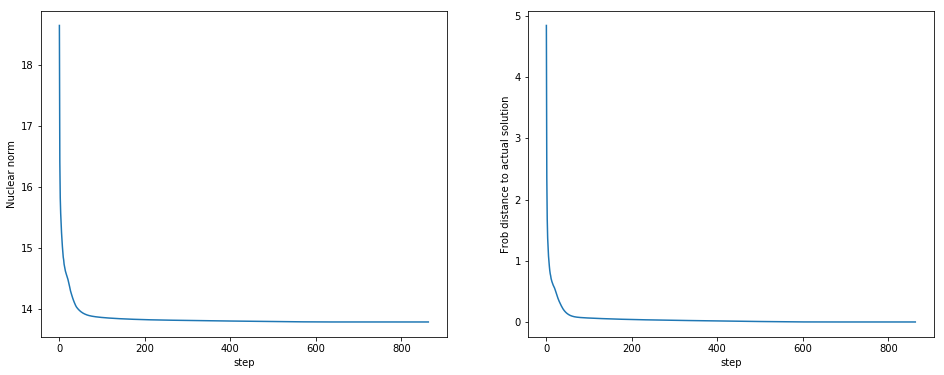

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

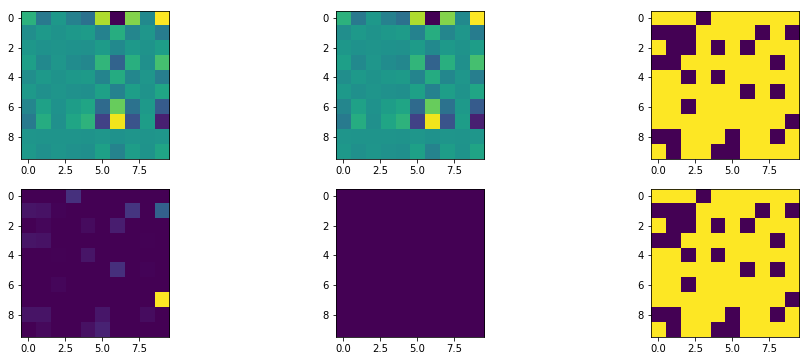

In [78]:
fig, ((ax1, ax2, ax3), (ax21, ax22, ax23)) = plt.subplots(2,3, figsize=(16,6))

ax1.imshow(current_point)
ax2.imshow(original)
ax3.imshow(current_point == original)

ax21.imshow(np.abs(current_point - original))
ax22.imshow(np.abs(current_point - original) < 1e-4)
ax23.imshow(mask)

## Pseudo-norms

In [80]:
A = np.array([2,3,4,5])
A**0.5

array([1.41421356, 1.73205081, 2.        , 2.23606798])

In [86]:
def obj_func(m):
    svd = np.linalg.svd(m, compute_uv=False)
    
    return np.sum(svd**0.5)**2 

def comp_grad(m, boolMask, obj_func):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))
                
    return grad

def comp_hessian(m, boolMask, of):
    """ Computes hessian (only diagonal) """
    epsilon = 1e-3
    
    hessian = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                row = []
                
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)
                
    return hessian


starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    #if i % 1000 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    descent = np.dot(np.linalg.inv(np.diag(comp_hessian(current_point,boolMask,obj_func))),
       comp_grad(current_point,boolMask,obj_func))
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point - 0.000001*descent_matrix
    
    #current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1 18.64025011827852 -3.335211417265782e-06 4.845676785494636 4 4 1.1
2 18.640246798025743 -3.320252776717325e-06 4.845689730517037 4 4 1.1
3 18.640243492691216 -3.3053345269706824e-06 4.845702677602506 4 4 1.1
4 18.640240202217182 -3.290474033690316e-06 4.84571562673318 4 4 1.1
5 18.6402369265581 -3.275659082646598e-06 4.845728577903573 4 4 1.1
6 18.640233665665775 -3.260892324163933e-06 4.845741531107862 4 4 1.1
7 18.64023041951078 -3.2461549963613834e-06 4.845754486357123 4 4 1.1
8 18.640227188034522 -3.2314762563601107e-06 4.84576744363501 4 4 1.1
9 18.640223971193254 -3.2168412680277925e-06 4.845780402932873 4 4 1.1
10 18.640220768940104 -3.2022531506470386e-06 4.845793364248484 4 4 1.1
11 18.640217581235973 -3.18770413088032e-06 4.845806327580849 4 4 1.1
12 18.64021440801968 -3.173216292395864e-06 4.845819292906179 4 4 1.1
13 18.640211249260805 -3.1587588757986396e-06 4.845832260235395 4 4 1.1
14 18.640208104915985 -3.14434482007

116 18.639955915767274 -1.8735621196697139e-06 4.8471777045669935 4 4 1.1
117 18.639954052997247 -1.8627700271167669e-06 4.8471908544738405 4 4 1.1
118 18.63995220099622 -1.852001027202732e-06 4.847204005928517 4 4 1.1
119 18.639950359728342 -1.84126787772243e-06 4.847217158917471 4 4 1.1
120 18.63994852917238 -1.8305559628117862e-06 4.847230313445193 4 4 1.1
121 18.63994670930617 -1.8198662097290708e-06 4.847243469512586 4 4 1.1
122 18.639944900090995 -1.8092151741200269e-06 4.847256627103858 4 4 1.1
123 18.639943101505615 -1.7985853801860685e-06 4.84726978622174 4 4 1.1
124 18.63994131351984 -1.787985773660239e-06 4.847282946860582 4 4 1.1
125 18.639939536114568 -1.777405273628574e-06 4.847296109021702 4 4 1.1
126 18.639937769254196 -1.7668603717879705e-06 4.84730927269682 4 4 1.1
127 18.639936012918852 -1.7563353438276863e-06 4.847322437887114 4 4 1.1
128 18.639934267072405 -1.7458464469655155e-06 4.847335604578945 4 4 1.1
129 18.6399325316976 -1.7353748056336826e-06 4.8473487727809

236 18.639802353486832 -7.479630461659781e-07 4.848765833761329 4 4 1.1
237 18.639801613670254 -7.398165777772192e-07 4.848779147265945 4 4 1.1
238 18.639800881986403 -7.316838512849699e-07 4.848792461978253 4 4 1.1
239 18.63980015840893 -7.235774717173626e-07 4.848805777887568 4 4 1.1
240 18.63979944293345 -7.154754797511487e-07 4.848819095005942 4 4 1.1
241 18.639798735534324 -7.073991277195546e-07 4.84883241331928 4 4 1.1
242 18.639798036189912 -6.993444117142644e-07 4.84884573282288 4 4 1.1
243 18.639797344889757 -6.913001548980446e-07 4.848859053519089 4 4 1.1
244 18.63979666161389 -6.832758678854134e-07 4.84887237540519 4 4 1.1
245 18.639795986347377 -6.752665129283741e-07 4.848885698481073 4 4 1.1
246 18.639795319070835 -6.672765415771664e-07 4.848899022740609 4 4 1.1
247 18.639794659773063 -6.59297771932188e-07 4.848912348189521 4 4 1.1
248 18.639794008435473 -6.51337590085177e-07 4.84892567482358 4 4 1.1
249 18.6397933650342 -6.434012718159465e-07 4.848939002630707 4 4 1.1
250

Text(0,0.5,'Frob distance to actual solution')

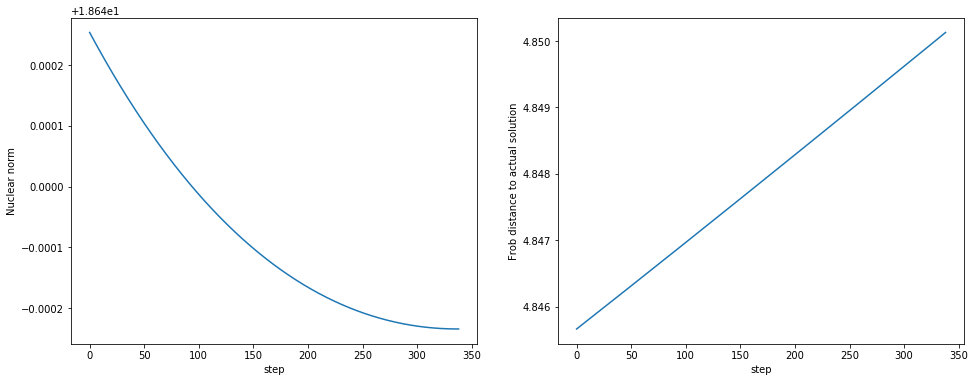

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

In [90]:
def obj_func(m):
    svd = np.linalg.svd(m, compute_uv=False)
    
    return np.sum(svd**0.5)

def comp_grad(m, boolMask, obj_func):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))
                
    return grad

def comp_hessian(m, boolMask, of):
    """ Computes hessian (only diagonal) """
    epsilon = 1e-3
    
    hessian = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                row = []
                
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)
                
    return hessian


starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    #if i % 1000 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    descent = np.dot(np.linalg.inv(np.diag(comp_hessian(current_point,boolMask,obj_func))),
       comp_grad(current_point,boolMask,obj_func))
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point - 0.00001*descent_matrix
    
    #current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1 18.640078874558945 -0.00017457893099148691 4.84574175077342 4 4 1.1
2 18.639913902651976 -0.00016497190696895814 4.845820876714511 4 4 1.1
3 18.639757545799736 -0.00015635685224069107 4.8459011086484844 4 4 1.1
4 18.639608969890226 -0.00014857590950967392 4.845982350244316 4 4 1.1
5 18.63946746516046 -0.00014150472976481865 4.846064517846558 4 4 1.1
6 18.639332421845857 -0.0001350433146036778 4.846147538308277 4 4 1.1
7 18.639203311725154 -0.0001291101207030465 4.8462313474702565 4 4 1.1
8 18.63907967327748 -0.00012363844767548926 4.846315888531307 4 4 1.1
9 18.63896110064668 -0.00011857263080017333 4.846401110907975 4 4 1.1
10 18.63884723494701 -0.00011386569966731486 4.84648696957039 4 4 1.1
11 18.638737756857232 -0.00010947808977945783 4.846573424052377 4 4 1.1
12 18.638632380806115 -0.00010537605111693438 4.84666043789554 4 4 1.1
13 18.63853085052913 -0.00010153027698578398 4.846747978198583 4 4 1.1
14 18.638432934789066 -9.7915

117 18.635339612814896 -1.0719704732764512e-06 4.856907840524582 4 4 1.1
118 18.63533883262436 -7.801905361759509e-07 4.857010052312409 4 4 1.1
119 18.635338340825022 -4.917993372544061e-07 4.857112310640974 4 4 1.1
120 18.63533813403448 -2.0679054202332736e-07 4.857214614973928 4 4 1.1
121 18.63533820897554 7.494105958016917e-08 4.857316964839294 4 4 1.1


Text(0,0.5,'Frob distance to actual solution')

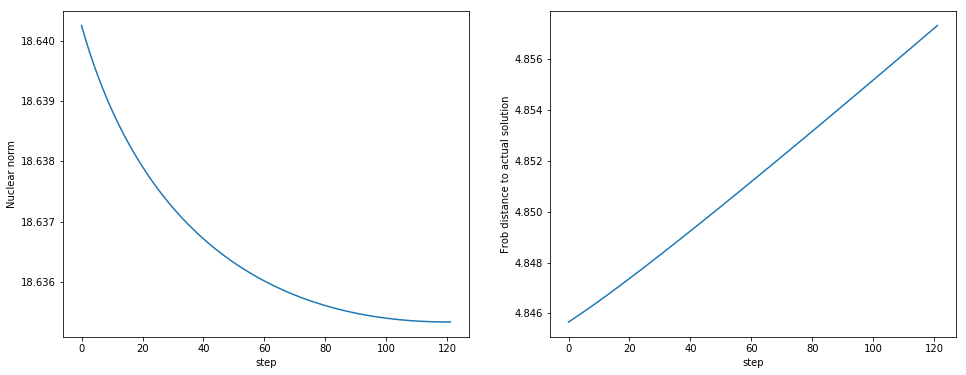

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")

Overall spikier functions above don't work well. Perhaps it's due to the problems with computing gradients and hessians.

Perhaps weighted sum of svd's could give better performance?

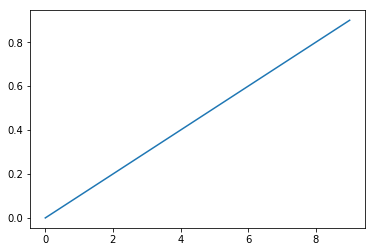

In [121]:
plt.plot(np.arange(n)/n)

Rescaling smaller eigenvalues to be larger doesn't seem to improve performace.

If rescaling could possibly improve performance, some smarter way of rescaling should be used.

In [126]:
def obj_func(m):
    svd = np.linalg.svd(m, compute_uv=False)
    
    return np.sum(svd*np.arange(n)**0.1)

def comp_grad(m, boolMask, obj_func):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3
    
    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j] and np.random.random() > 1 - portion:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))
                
    return grad

def comp_hessian(m, boolMask, of):
    """ Computes hessian (only diagonal) """
    epsilon = 1e-3
    
    hessian = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                row = []
                
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)
                
    return hessian


starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

norms = []
distances = []
sing_vals = []

current_point = starting_point

#pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
#          interpolation='nearest', vmin=0, vmax=1)
#pl.colorbar()


initial_s = 4
s = 4
portion = 1.1
for i in range(100000):
    cur_norm = np.linalg.norm(current_point,'nuc')
    norms.append(cur_norm)
    sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
    distances.append(np.linalg.norm(current_point-original,'fro'))
    diff = cur_norm - prev_norm
    
    # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
    #portion = 1 - np.exp(-1/(20*s))
    #if i % 1000 == 0:
    print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
    prev_norm = cur_norm
    if diff >= 0 and i > 1:
        break
    
    ### slowest part of the code ###
    descent = np.dot(np.linalg.inv(np.diag(comp_hessian(current_point,boolMask,obj_func))),
       comp_grad(current_point,boolMask,obj_func))
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point - 0.01*descent_matrix
    
    #current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

0 18.640253453489937 0.0 4.8456638425363545 4 4 1.1
1 18.34671465262882 -0.2935388008611177 4.570013101689269 4 4 1.1
2 18.097350805671983 -0.249363846956836 4.316795015933274 4 4 1.1
3 17.877999256162703 -0.21935154950928037 4.082618698126713 4 4 1.1
4 17.682201222495703 -0.19579803366699977 3.865730381420211 4 4 1.1
5 17.50568996615901 -0.17651125633669196 3.6648198491315624 4 4 1.1
6 17.345727577332045 -0.15996238882696545 3.4787412918301133 4 4 1.1
7 17.20023880618989 -0.14548877114215486 3.306468889648692 4 4 1.1
8 17.067558572465643 -0.13268023372424764 3.1470538457860933 4 4 1.1
9 16.94629999658879 -0.12125857587685118 2.999603566118281 4 4 1.1
10 16.841599642338206 -0.10470035425058555 2.8643587048338532 4 4 1.1
11 16.736551438106467 -0.1050482042317391 2.7388424671183182 4 4 1.1
12 16.643272141274856 -0.09327929683161074 2.622417554975375 4 4 1.1
13 16.584648474660774 -0.058623666614082026 2.524236862517531 4 4 1.1
14 16.501895917929648 -0.08275255673112625 2.425782837281069 4

120 14.841789319355497 -0.0043390065231676544 0.8298488331309778 4 4 1.1
121 14.837473240900708 -0.004316078454788652 0.8267133619993596 4 4 1.1
122 14.833168949148963 -0.004304291751745737 0.8235777713986864 4 4 1.1
123 14.828885445248737 -0.004283503900225583 0.820445743510167 4 4 1.1
124 14.824622977584664 -0.004262467664073455 0.8173162480291443 4 4 1.1
125 14.82045735057875 -0.004165627005914274 0.8142154518468877 4 4 1.1
126 14.816377769158759 -0.004079581419990319 0.8111533629007666 4 4 1.1
127 14.812368198885471 -0.004009570273288077 0.8081297912480951 4 4 1.1
128 14.808423363501724 -0.003944835383746792 0.8051432292372751 4 4 1.1
129 14.804737940923728 -0.0036854225779965333 0.8022278827328041 4 4 1.1
130 14.801069415919567 -0.0036685250041603723 0.7993082973038407 4 4 1.1
131 14.797374571175856 -0.0036948447437108456 0.7963699199676426 4 4 1.1
132 14.793668070866518 -0.0037065003093381677 0.7934161972967606 4 4 1.1
133 14.78994845418866 -0.0037196166778574735 0.79044616816169

234 14.47785892914162 -0.0023341766717006607 0.5343430789683881 4 4 1.1
235 14.475537545712356 -0.0023213834292636903 0.5323571760756991 4 4 1.1
236 14.473228694279275 -0.0023088514330815713 0.5303804031530094 4 4 1.1
237 14.470931980919174 -0.002296713360101066 0.5284125509219509 4 4 1.1
238 14.46864699417444 -0.0022849867447334304 0.5264534951962098 4 4 1.1
239 14.466372224519462 -0.0022747696549778595 0.5245026677758743 4 4 1.1
240 14.464105446020254 -0.0022667784992087547 0.5225589001913823 4 4 1.1
241 14.461849826906938 -0.002255619113315177 0.5206234480411521 4 4 1.1
242 14.459613699888619 -0.0022361270183193227 0.5186997224480235 4 4 1.1
243 14.457408562846465 -0.0022051370421536376 0.5167921716960612 4 4 1.1
244 14.45524431602477 -0.0021642468216960253 0.5149041729144629 4 4 1.1
245 14.453141740877596 -0.002102575147173269 0.5130454238691152 4 4 1.1
246 14.451081665531765 -0.0020600753458310805 0.5112077747504891 4 4 1.1
247 14.448970738307315 -0.0021109272244501653 0.509347714

349 14.278113732730366 -0.001228124279045062 0.36096494396566 4 4 1.1
350 14.27689339300625 -0.0012203397241172809 0.35993403731668183 4 4 1.1
351 14.275680807288687 -0.0012125857175622201 0.35891064989241284 4 4 1.1
352 14.274475945017794 -0.0012048622708924484 0.35789475626794376 4 4 1.1
353 14.273278775649015 -0.0011971693687797824 0.3568863304587524 4 4 1.1
354 14.272089268685823 -0.0011895069631915334 0.35588534595750554 4 4 1.1
355 14.270907393714777 -0.0011818749710457155 0.3548917757798988 4 4 1.1
356 14.269733120442135 -0.0011742732726425231 0.3539055925187774 4 4 1.1
357 14.268566418732206 -0.0011667017099288302 0.35292676840621384 4 4 1.1
358 14.267407258652993 -0.0011591600792133505 0.35195527538680244 4 4 1.1
359 14.266255610537266 -0.0011516481157265446 0.3509910852059829 4 4 1.1
360 14.265111445073455 -0.001144165463811575 0.3500341695205052 4 4 1.1
361 14.263975079519492 -0.0011363655539629036 0.34908470263296976 4 4 1.1
362 14.262846979980495 -0.0011280995389970627 0.3

463 14.183432487074466 -0.0005648207486999013 0.2834701500720711 4 4 1.1
464 14.1828709536981 -0.000561533376366441 0.28302195181020406 4 4 1.1
465 14.18231268905969 -0.0005582646384088008 0.2825765591832264 4 4 1.1
466 14.181757674124137 -0.0005550149355535439 0.2821339565540145 4 4 1.1
467 14.181205889450199 -0.0005517846739380161 0.2816941278007065 4 4 1.1
468 14.180657315186458 -0.0005485742637407753 0.2812570563223638 4 4 1.1
469 14.180111931068973 -0.0005453841174851703 0.28082272504595596 4 4 1.1
470 14.179569716420158 -0.0005422146488154311 0.280391116434347 4 4 1.1
471 14.17903065014934 -0.0005390662708180116 0.2799622124954857 4 4 1.1
472 14.178494710754666 -0.0005359393946733348 0.2795359947926335 4 4 1.1
473 14.177961876326133 -0.0005328344285331355 0.2791124444553383 4 4 1.1
474 14.177432124550005 -0.0005297517761277959 0.278691542191399 4 4 1.1
475 14.176905432714449 -0.0005266918355566474 0.278273268299601 4 4 1.1
476 14.176381777716276 -0.0005236549981724181 0.277857602

577 14.134802021003843 -0.00033491797020346326 0.24558585260985466 4 4 1.1
578 14.134468180675547 -0.0003338403282953095 0.24533360432281107 4 4 1.1
579 14.13413541134275 -0.00033276933279680065 0.2450822932582519 4 4 1.1
580 14.133803706953886 -0.0003317043888646509 0.24483191457663778 4 4 1.1
581 14.133473062043686 -0.000330644910199851 0.24458246390290359 4 4 1.1
582 14.133143471723146 -0.00032959032053980764 0.24433393731578912 4 4 1.1
583 14.1328149316678 -0.0003285400553458828 0.24408633133591093 4 4 1.1
584 14.132487438104798 -0.0003274935630024345 0.2438396429129195 4 4 1.1
585 14.132160987798478 -0.00032645030631961447 0.243593869411603 4 4 1.1
586 14.131835578034886 -0.0003254097635920772 0.2433490085972775 4 4 1.1
587 14.131511206605191 -0.0003243714296949918 0.24310505862048695 4 4 1.1
588 14.13118787178827 -0.0003233348169207062 0.2428620180011492 4 4 1.1
589 14.13086557233254 -0.0003222994557301462 0.2426198856123294 4 4 1.1
590 14.130544307437095 -0.00032126489544559433 

696 14.101202639429811 -0.0002832186245793622 0.22089826026897247 4 4 1.1
697 14.100917695129802 -0.0002849443000094709 0.22069037533848054 4 4 1.1
698 14.100631000121911 -0.0002866950078903585 0.2204811055532204 4 4 1.1
699 14.100342524784653 -0.0002884753372587312 0.22027042808487068 4 4 1.1
700 14.100052238095813 -0.0002902866888394584 0.22005832052255414 4 4 1.1
701 14.099760112986019 -0.00029212510979448325 0.21984476263555952 4 4 1.1
702 14.099466125000598 -0.00029398798542068505 0.21962973654135876 4 4 1.1
703 14.099170251232215 -0.000295873768383359 0.21941322671533603 4 4 1.1
704 14.098872471908061 -0.00029777932415342434 0.2191952196690561 4 4 1.1
705 14.09857276655097 -0.00029970535709189505 0.21897570253077447 4 4 1.1
706 14.098271118192207 -0.0003016483587625629 0.21875466537573138 4 4 1.1
707 14.097967513306816 -0.000303604885390385 0.21853210118725788 4 4 1.1
708 14.09766194177686 -0.0003055715299566941 0.21830800583622745 4 4 1.1
709 14.097354396871829 -0.00030754490503

813 14.061588063776343 -0.00031925935252097304 0.1925688983741827 4 4 1.1
814 14.06126984010133 -0.00031822367501277427 0.19235499241038997 4 4 1.1
815 14.06095265393671 -0.00031718616462050875 0.19214206195857636 4 4 1.1
816 14.060636506867827 -0.00031614706888305477 0.19193010572052718 4 4 1.1
817 14.060321400239749 -0.00031510662807754386 0.19171912221234227 4 4 1.1
818 14.060007335164347 -0.00031406507540232553 0.19150910977122587 4 4 1.1
819 14.059694312527231 -0.00031302263711552314 0.1913000665621288 4 4 1.1
820 14.059382332994543 -0.00031197953268780054 0.19109199058416515 4 4 1.1
821 14.05907139701952 -0.0003109359750226304 0.1908848796768498 4 4 1.1
822 14.058761504849057 -0.00030989217046339945 0.19067873152621978 4 4 1.1
823 14.058452656530001 -0.0003088483190563096 0.19047354367072475 4 4 1.1
824 14.058144851915305 -0.0003078046146960389 0.19026931350695436 4 4 1.1
825 14.057838091170277 -0.00030676074502800077 0.19006603833384375 4 4 1.1
826 14.05753237364428 -0.000305717

932 14.030394220532884 -0.00021514282669343743 0.1729109062801368 4 4 1.1
933 14.03017969761803 -0.00021452291485424269 0.1727842117196742 4 4 1.1
934 14.029965790553137 -0.00021390706489299305 0.17265797957817233 4 4 1.1
935 14.029752495301839 -0.0002132952512976516 0.17253220613490877 4 4 1.1
936 14.029539807853467 -0.00021268744837144027 0.17240688769891344 4 4 1.1
937 14.029327724223203 -0.00021208363026481436 0.17228202060891895 4 4 1.1
938 14.029116240452225 -0.0002114837709772388 0.17215760123330068 4 4 1.1
939 14.028905352607778 -0.0002108878444477824 0.17203362597000482 4 4 1.1
940 14.028695056783329 -0.00021029582444853645 0.17191009124646955 4 4 1.1
941 14.0284853490986 -0.00020970768472849954 0.17178699351951798 4 4 1.1
942 14.02827622569956 -0.00020912339904022303 0.17166432927521422 4 4 1.1
943 14.028067682758092 -0.000208542941468437 0.17154209502854192 4 4 1.1
944 14.027859716469465 -0.00020796628862740363 0.1714202873218983 4 4 1.1
945 14.02765232299526 -0.000207393474

1042 14.009757389269557 -0.00016607644517385722 0.16109462877802222 4 4 1.1
1043 14.009591628447017 -0.00016576082254005087 0.1610019871065909 4 4 1.1
1044 14.009426181463208 -0.00016544698380904777 0.16090954340259092 4 4 1.1
1045 14.009261046568147 -0.00016513489506131407 0.1608172962643553 4 4 1.1
1046 14.009096222103002 -0.00016482446514487492 0.16072524433457952 4 4 1.1
1047 14.008931706501349 -0.00016451560165364754 0.16063338630013657 4 4 1.1
1048 14.008767498264948 -0.00016420823640039828 0.160541720882259 4 4 1.1
1049 14.008603595943407 -0.00016390232154073203 0.16045024682841078 4 4 1.1
1050 14.00843999812207 -0.0001635978213379019 0.16035896290746385 4 4 1.1
1051 14.008276703415397 -0.00016329470667209023 0.16026786790704484 4 4 1.1
1052 14.008113710463228 -0.0001629929521698159 0.1601769606320635 4 4 1.1
1053 14.007951017928654 -0.00016269253457323885 0.16008623990385715 4 4 1.1
1054 14.00778862449655 -0.0001623934321042242 0.15999570455964832 4 4 1.1
1055 14.00762652887252

1153 13.99300232587156 -0.0001381366920245597 0.15179088523912218 4 4 1.1
1154 13.992864394392278 -0.00013793147928176097 0.15171437777492863 4 4 1.1
1155 13.992726667569105 -0.00013772682317281237 0.15163797913922908 4 4 1.1
1156 13.992589144852529 -0.00013752271657629933 0.15156168890379876 4 4 1.1
1157 13.992451825700172 -0.00013731915235659642 0.15148550664607344 4 4 1.1
1158 13.992314709576721 -0.00013711612345090884 0.1514094319491253 4 4 1.1
1159 13.992177795953904 -0.0001369136228177581 0.15133346440163725 4 4 1.1
1160 13.992041084310452 -0.0001367116434511928 0.15125760359787535 4 4 1.1
1161 13.991904574132098 -0.00013651017835414336 0.15118184913766503 4 4 1.1
1162 13.991768264911476 -0.00013630922062191075 0.15110620062636151 4 4 1.1
1163 13.99163215614817 -0.00013610876330716337 0.15103065767482426 4 4 1.1
1164 13.991496247348602 -0.00013590879956737467 0.15095521989938654 4 4 1.1
1165 13.991360538026036 -0.00013570932256534718 0.15087988692182602 4 4 1.1
1166 13.9912250277

1267 13.978526471858974 -0.00011651791789901722 0.14371708479071127 4 4 1.1
1268 13.978410133721844 -0.0001163381371291905 0.14365166808553154 4 4 1.1
1269 13.978293975285146 -0.00011615843669865455 0.14358634105833482 4 4 1.1
1270 13.978177996478976 -0.0001159788061695366 0.1435211036456566 4 4 1.1
1271 13.978062197243576 -0.00011579923540061543 0.143455955788637 4 4 1.1
1272 13.977946577529144 -0.00011561971443185826 0.1433908974329445 4 4 1.1
1273 13.977831137270828 -0.00011544025831611293 0.1433259285287846 4 4 1.1
1274 13.977715876374331 -0.00011526089649649407 0.14326104902985756 4 4 1.1
1275 13.977600794815901 -0.00011508155843031886 0.14319625889191168 4 4 1.1
1276 13.977485892583035 -0.0001149022328661431 0.14313155807576475 4 4 1.1
1277 13.977371169674782 -0.00011472290825231823 0.14306694654748467 4 4 1.1
1278 13.977256626102179 -0.00011454357260376469 0.143002424278607 4 4 1.1
1279 13.97714226195181 -0.00011436415036847336 0.1429379912464104 4 4 1.1
1280 13.9770280773047 -0

1377 13.966784868538857 -9.754526702465682e-05 0.13704569245606896 4 4 1.1
1378 13.96668748140698 -9.738713187701364e-05 0.136989797560555 4 4 1.1
1379 13.966590251806123 -9.72296008576734e-05 0.1369339832087813 4 4 1.1
1380 13.96649317912129 -9.707268483261089e-05 0.1368782490590047 4 4 1.1
1381 13.966396262726523 -9.691639476727687e-05 0.13682259476317868 4 4 1.1
1382 13.966299501984839 -9.676074168396553e-05 0.13676701996690832 4 4 1.1
1383 13.966202896248127 -9.660573671155248e-05 0.13671152430940417 4 4 1.1
1384 13.966106444857097 -9.645139103042766e-05 0.13665610742343243 4 4 1.1
1385 13.966010147141171 -9.629771592578606e-05 0.1366007689352644 4 4 1.1
1386 13.965914002418383 -9.614472278762776e-05 0.13654550846462182 4 4 1.1
1387 13.965818009995296 -9.59924230876652e-05 0.1364903256246232 4 4 1.1
1388 13.965722169166874 -9.584082842195585e-05 0.13643522002172312 4 4 1.1
1389 13.965626479213329 -9.56899535449196e-05 0.13638019125126574 4 4 1.1
1390 13.965530939404056 -9.553980927

1489 13.956597092591528 -9.014088733216852e-05 0.13114292335865801 4 4 1.1
1490 13.956506596157055 -9.049643447234246e-05 0.13109015368305937 4 4 1.1
1491 13.956415701822394 -9.089433466158425e-05 0.1310371629088719 4 4 1.1
1492 13.956324364219991 -9.133760240231936e-05 0.1309839264396058 4 4 1.1
1493 13.95623253592369 -9.182829630205447e-05 0.13093041852675946 4 4 1.1
1494 13.956140170735809 -9.236518788036108e-05 0.13087661403190876 4 4 1.1
1495 13.956047327419205 -9.284331660452949e-05 0.1308225438502161 4 4 1.1
1496 13.955954014146288 -9.331327291661751e-05 0.13076821247101914 4 4 1.1
1497 13.955860243005965 -9.377114032282918e-05 0.13071362673648018 4 4 1.1
1498 13.955766030765405 -9.421224056005428e-05 0.13065879624560398 4 4 1.1
1499 13.955671396449077 -9.463431632816821e-05 0.13060373204899442 4 4 1.1
1500 13.955576359736844 -9.503671223320964e-05 0.13054844576171545 4 4 1.1
1501 13.955480940133876 -9.541960296743923e-05 0.1304929490802508 4 4 1.1
1502 13.955385156649488 -9.578

1601 13.946098324228993 -8.242629452936967e-05 0.12507641308996872 4 4 1.1
1602 13.946016171888951 -8.215234004183003e-05 0.1250285376745804 4 4 1.1
1603 13.945934292510605 -8.187937834591708e-05 0.12498080029470911 4 4 1.1
1604 13.94585268508083 -8.160742977558755e-05 0.12493320033550165 4 4 1.1
1605 13.945771348567733 -8.13365130962751e-05 0.12488573717561967 4 4 1.1
1606 13.945690281921053 -8.106664668083852e-05 0.12483841018778231 4 4 1.1
1607 13.945609484072353 -8.079784869963191e-05 0.12479121873898512 4 4 1.1
1608 13.945528953937709 -8.053013464426328e-05 0.1247441621908568 4 4 1.1
1609 13.945448690417933 -8.026351977541424e-05 0.12469723990077258 4 4 1.1
1610 13.94536869239917 -7.999801876401591e-05 0.12465045122231051 4 4 1.1
1611 13.945288958753657 -7.973364551183693e-05 0.12460379550567602 4 4 1.1
1612 13.945209488340646 -7.947041301115121e-05 0.12455727209809715 4 4 1.1
1613 13.945130280007541 -7.92083331049298e-05 0.1245108803441997 4 4 1.1
1614 13.945051332590829 -7.89474

1711 13.938448359835366 -5.913019496617267e-05 0.12050110415822554 4 4 1.1
1712 13.938389383909131 -5.897592623504977e-05 0.12046471555177204 4 4 1.1
1713 13.938330561385646 -5.882252348499151e-05 0.12042840165928763 4 4 1.1
1714 13.938271891401822 -5.8669983824088945e-05 0.12039216204021114 4 4 1.1
1715 13.938213373097387 -5.8518304435040136e-05 0.12035599625547648 4 4 1.1
1716 13.938155005614782 -5.8367482605348187e-05 0.12031990386746688 4 4 1.1
1717 13.938096788099026 -5.8217515755742966e-05 0.1202838844399689 4 4 1.1
1718 13.938038719697685 -5.806840134070512e-05 0.12024793753812721 4 4 1.1
1719 13.937980799559528 -5.792013815764108e-05 0.12021206272839824 4 4 1.1
1720 13.937923026836774 -5.777272275331313e-05 0.12017625957858481 4 4 1.1
1721 13.93786540068387 -5.762615290372253e-05 0.12014052765771392 4 4 1.1
1722 13.937807920262388 -5.748042148212562e-05 0.12010486653608256 4 4 1.1
1723 13.937750584737369 -5.7335525019297506e-05 0.12006927578492965 4 4 1.1
1724 13.93769339326852

1825 13.932519405011837 -4.661272690498208e-05 0.11673596825210934 4 4 1.1
1826 13.932472862527074 -4.654248476221312e-05 0.11670555361669997 4 4 1.1
1827 13.93242638973654 -4.6472790534934916e-05 0.11667517209293589 4 4 1.1
1828 13.932379986097798 -4.640363874131026e-05 0.1166448234152332 4 4 1.1
1829 13.932333651073888 -4.633502391016009e-05 0.1166145073207038 4 4 1.1
1830 13.932287384133256 -4.6266940632477827e-05 0.11658422354914554 4 4 1.1
1831 13.93224118474978 -4.619938347616426e-05 0.11655397184303172 4 4 1.1
1832 13.9321950524027 -4.613234708017444e-05 0.11652375194750036 4 4 1.1
1833 13.932148986578932 -4.6065823767094116e-05 0.11649356361277843 4 4 1.1
1834 13.932102986788266 -4.599979066632898e-05 0.11646340661056402 4 4 1.1
1835 13.932057052527371 -4.5934260894497925e-05 0.11643328069504354 4 4 1.1
1836 13.932011183298153 -4.586922921845371e-05 0.11640318562297731 4 4 1.1
1837 13.931965378607758 -4.5804690394390946e-05 0.11637312115368725 4 4 1.1
1838 13.931919637968523 -4

1937 13.927646116706395 -4.1099054536530844e-05 0.11348970284403546 4 4 1.1
1938 13.92760505295169 -4.1063754704140365e-05 0.11346186460801853 4 4 1.1
1939 13.927564024346688 -4.1028605002324525e-05 0.11343404272225992 4 4 1.1
1940 13.927523030742856 -4.099360383236217e-05 0.11340623711619292 4 4 1.1
1941 13.927482071993373 -4.095874948362166e-05 0.11337844772007245 4 4 1.1
1942 13.927441147953038 -4.09240403342892e-05 0.113350674464964 4 4 1.1
1943 13.927400258478254 -4.0889474783867286e-05 0.11332291728273228 4 4 1.1
1944 13.927359403427008 -4.085505124606925e-05 0.11329517610603024 4 4 1.1
1945 13.927318582658895 -4.082076811329216e-05 0.11326745086828788 4 4 1.1
1946 13.927277796035035 -4.078662385964549e-05 0.11323974150370145 4 4 1.1
1947 13.927237043418067 -4.075261696812049e-05 0.11321204794722241 4 4 1.1
1948 13.927196324672167 -4.071874590039215e-05 0.11318437013454662 4 4 1.1
1949 13.927155639662985 -4.0685009182084286e-05 0.11315670800210345 4 4 1.1
1950 13.92711498825764 -

2054 13.923050787574489 -3.7682174157893655e-05 0.11032971206470414 4 4 1.1
2055 13.923013130221454 -3.7657353034958874e-05 0.11030345381192984 4 4 1.1
2056 13.922975497636447 -3.763258500733002e-05 0.1102772070155941 4 4 1.1
2057 13.922937889766827 -3.760786962025975e-05 0.11025097165104313 4 4 1.1
2058 13.922900306560358 -3.7583206468738695e-05 0.11022474769385256 4 4 1.1
2059 13.922862747965269 -3.7558595089137725e-05 0.11019853511982403 4 4 1.1
2060 13.922825213930208 -3.753403506046027e-05 0.11017233390497816 4 4 1.1
2061 13.922787704404232 -3.750952597592061e-05 0.11014614402554389 4 4 1.1
2062 13.922750219336754 -3.7485067478471024e-05 0.1101199654579416 4 4 1.1
2063 13.922712758677577 -3.7460659177313005e-05 0.11009379817875818 4 4 1.1
2064 13.9226753223768 -3.743630077579496e-05 0.1100676421647091 4 4 1.1
2065 13.922637911722465 -3.741065433615631e-05 0.11004149739257853 4 4 1.1
2066 13.922600526630484 -3.7385091980368657e-05 0.11001536365522886 4 4 1.1
2067 13.9225631651798 -

2170 13.918832338058763 -3.51852724786994e-05 0.10735169599783012 4 4 1.1
2171 13.918797171508965 -3.516654979840439e-05 0.1073265608691878 4 4 1.1
2172 13.9187620236362 -3.514787276515108e-05 0.10730143396419878 4 4 1.1
2173 13.918726894394865 -3.512924133453055e-05 0.10727631525824466 4 4 1.1
2174 13.918691783739407 -3.5110655458581164e-05 0.10725120472674542 4 4 1.1
2175 13.918656691624363 -3.5092115043156014e-05 0.10722610234516378 4 4 1.1
2176 13.918621618004313 -3.5073620050951604e-05 0.1072010080890102 4 4 1.1
2177 13.918586562833918 -3.505517039492645e-05 0.10717592193384806 4 4 1.1
2178 13.918551526067924 -3.5036765993368135e-05 0.10715084385529905 4 4 1.1
2179 13.918516507661154 -3.501840676989332e-05 0.10712577382904856 4 4 1.1
2180 13.918481507568536 -3.5000092617920586e-05 0.10710071183085208 4 4 1.1
2181 13.918446525745082 -3.498182345396117e-05 0.10707565783654119 4 4 1.1
2182 13.918411562145904 -3.4963599178539084e-05 0.10705061182203034 4 4 1.1
2183 13.91837661672625 -

2287 13.914836633572387 -3.3209634439756996e-05 0.10446369196396108 4 4 1.1
2288 13.914803438630823 -3.3194941563507996e-05 0.10443943413780844 4 4 1.1
2289 13.914770258343234 -3.318028758947378e-05 0.10441518272709846 4 4 1.1
2290 13.914737092670558 -3.31656726757501e-05 0.10439093771034208 4 4 1.1
2291 13.91470394157343 -3.3151097127870344e-05 0.1043666990658943 4 4 1.1
2292 13.914670805012118 -3.313656131176401e-05 0.10434246677197202 4 4 1.1
2293 13.914637682946584 -3.312206553474084e-05 0.10431824080669333 4 4 1.1
2294 13.914604575336508 -3.3107610075688854e-05 0.10429402114813063 4 4 1.1
2295 13.914571482141374 -3.3093195133560016e-05 0.104269807774369 4 4 1.1
2296 13.914538403320602 -3.3078820772303175e-05 0.10424560066356174 4 4 1.1
2297 13.914505338833699 -3.306448690310049e-05 0.10422139979397792 4 4 1.1
2298 13.914472288640264 -3.3050193435357755e-05 0.10419720514403989 4 4 1.1
2299 13.91443925270015 -3.3035940113279594e-05 0.10417301669235059 4 4 1.1
2300 13.914406230973464

2401 13.911138275451338 -3.1754034289122046e-05 0.10173520468718707 4 4 1.1
2402 13.911106532523071 -3.174292826635394e-05 0.10171156689798998 4 4 1.1
2403 13.911074800674637 -3.173184843419108e-05 0.10168793374533777 4 4 1.1
2404 13.911043079879814 -3.172079482283152e-05 0.10166430521655759 4 4 1.1
2405 13.911011370112396 -3.1709767418064416e-05 0.10164068129902314 4 4 1.1
2406 13.910979671346142 -3.169876625364054e-05 0.10161706198015652 4 4 1.1
2407 13.910947983554816 -3.1687791326007186e-05 0.10159344724742972 4 4 1.1
2408 13.910916306712206 -3.167684261029535e-05 0.1015698370883659 4 4 1.1
2409 13.910884640792087 -3.166592011893954e-05 0.10154623149054061 4 4 1.1
2410 13.910852985768253 -3.165502383417618e-05 0.10152263044158288 4 4 1.1
2411 13.910821341614525 -3.164415372758356e-05 0.10149903392917603 4 4 1.1
2412 13.910789708304742 -3.163330978317447e-05 0.10147544194105855 4 4 1.1
2413 13.910758085812748 -3.162249199384348e-05 0.10145185446502492 4 4 1.1
2414 13.910726474112433

2516 13.907554148313993 -3.063955829141207e-05 0.09904464256649874 4 4 1.1
2517 13.907523517235655 -3.063107833867207e-05 0.09902147392631859 4 4 1.1
2518 13.907492894620084 -3.062261557040813e-05 0.09899830895599386 4 4 1.1
2519 13.907462280450149 -3.0614169935105906e-05 0.09897514765001471 4 4 1.1
2520 13.907431674708768 -3.060574138125105e-05 0.09895199000288599 4 4 1.1
2521 13.907401077378868 -3.059732989996178e-05 0.09892883600912623 4 4 1.1
2522 13.907370488443425 -3.0588935443276455e-05 0.09890568566326706 4 4 1.1
2523 13.907339907885477 -3.0580557947246234e-05 0.09888253895985229 4 4 1.1
2524 13.907309335688069 -3.05721974083184e-05 0.09885939589343719 4 4 1.1
2525 13.90727877183431 -3.05638537589914e-05 0.09883625645858765 4 4 1.1
2526 13.907248216307295 -3.055552701525244e-05 0.09881312064987946 4 4 1.1
2527 13.907217669090208 -3.054721708650732e-05 0.09878998846189752 4 4 1.1
2528 13.907187130166227 -3.053892398163782e-05 0.09876685988923513 4 4 1.1
2529 13.907156599518574 -

2630 13.904112624830026 -2.9784108297903344e-05 0.09642556924584622 4 4 1.1
2631 13.904082847226439 -2.9777603586467194e-05 0.09640277676815208 4 4 1.1
2632 13.904053076113767 -2.9771112671994615e-05 0.09637998719577424 4 4 1.1
2633 13.904023311478307 -2.9764635460338695e-05 0.09635720052455315 4 4 1.1
2634 13.903993553306469 -2.9758171837812597e-05 0.0963344167503804 4 4 1.1
2635 13.903963801584744 -2.9751721724480262e-05 0.09631163586919558 4 4 1.1
2636 13.903934056299704 -2.9745285040405633e-05 0.09628885787698302 4 4 1.1
2637 13.903904317438046 -2.9738861657691018e-05 0.09626608276976892 4 4 1.1
2638 13.903874584986509 -2.9732451537256566e-05 0.09624331054361839 4 4 1.1
2639 13.90384485893191 -2.972605459916622e-05 0.09622054119463279 4 4 1.1
2640 13.9038151392609 -2.971967101039752e-05 0.09619777471894601 4 4 1.1
2641 13.903785425960463 -2.9713300436995382e-05 0.09617501111274225 4 4 1.1
2642 13.903755719017632 -2.9706942830998173e-05 0.09615225037223545 4 4 1.1
2643 13.9037260184

2754 13.900465956673699 -2.9066250530007665e-05 0.09362044217936051 4 4 1.1
2755 13.9004368955898 -2.9061083898440643e-05 0.0935979866774344 4 4 1.1
2756 13.900407839663199 -2.9055926601628812e-05 0.09357553373514456 4 4 1.1
2757 13.90037878888457 -2.905077862891403e-05 0.09355308334955335 4 4 1.1
2758 13.90034974324487 -2.904563969963192e-05 0.09353063551774445 4 4 1.1
2759 13.900320702734966 -2.9040509904376677e-05 0.09350819023674159 4 4 1.1
2760 13.900291667345675 -2.9035389291109936e-05 0.09348574750360077 4 4 1.1
2761 13.900262637068122 -2.9030277552521966e-05 0.09346330731554157 4 4 1.1
2762 13.900233611892784 -2.9025175338759368e-05 0.09344086966936725 4 4 1.1
2763 13.900204591810088 -2.902008269600742e-05 0.09341843456184422 4 4 1.1
2764 13.900175576810485 -2.9014999602949842e-05 0.09339600198970015 4 4 1.1
2765 13.900146566884164 -2.9009926320711088e-05 0.09337357194957453 4 4 1.1
2766 13.900117562022228 -2.9004861936243742e-05 0.09335114443889028 4 4 1.1
2767 13.900088562215

2863 13.89732567884337 -2.8585322342067343e-05 0.09118610927201255 4 4 1.1
2864 13.897297097383337 -2.8581460032484074e-05 0.09116388673702536 4 4 1.1
2865 13.897268519777164 -2.857760617303029e-05 0.09114166613833316 4 4 1.1
2866 13.897239946016276 -2.857376088805097e-05 0.09111944747274174 4 4 1.1
2867 13.897211376092017 -2.8569924259258528e-05 0.09109723073692781 4 4 1.1
2868 13.897182809995611 -2.8566096405668873e-05 0.09107501592743325 4 4 1.1
2869 13.897154247718188 -2.8562277423205273e-05 0.09105280304066002 4 4 1.1
2870 13.897125689250737 -2.8558467450423564e-05 0.09103059207286598 4 4 1.1
2871 13.897097134584143 -2.8554666593905154e-05 0.09100838302016241 4 4 1.1
2872 13.897068583709144 -2.8550874999311304e-05 0.09098617587851367 4 4 1.1
2873 13.897040036616373 -2.854709277144707e-05 0.09096397064373914 4 4 1.1
2874 13.897011493296354 -2.8543320018670215e-05 0.09094176731151779 4 4 1.1
2875 13.89698295373947 -2.8539556884865647e-05 0.09091956587739526 4 4 1.1
2876 13.896954417

2977 13.894090270908826 -2.8189105634623957e-05 0.08866431556698769 4 4 1.1
2978 13.894062085178017 -2.8185730808871767e-05 0.08864229547523045 4 4 1.1
2979 13.894033902822898 -2.8182355119810154e-05 0.08862027720552196 4 4 1.1
2980 13.894005723844353 -2.8178978544346478e-05 0.08859826076051093 4 4 1.1
2981 13.893977548243221 -2.817560113221873e-05 0.08857624614283365 4 4 1.1
2982 13.893949376020363 -2.8172222858557916e-05 0.08855423335511393 4 4 1.1
2983 13.893921207176604 -2.816884375889117e-05 0.08853222239996299 4 4 1.1
2984 13.893893041712795 -2.81654638083495e-05 0.08851021327997935 4 4 1.1
2985 13.893864879629735 -2.8162083060223608e-05 0.08848820599774881 4 4 1.1
2986 13.893836720928245 -2.81587014896445e-05 0.0884662005558445 4 4 1.1
2987 13.893808565609143 -2.8155319101941245e-05 0.08844419695682677 4 4 1.1
2988 13.893780413673197 -2.8151935946851836e-05 0.08842219520324314 4 4 1.1
2989 13.893752265121211 -2.814855198529642e-05 0.08840019529762849 4 4 1.1
2990 13.893724119953

3093 13.890843408850326 -2.7793686260935146e-05 0.08612272788605932 4 4 1.1
3094 13.890815618591642 -2.7790258684490254e-05 0.08610093393439013 4 4 1.1
3095 13.890787831760626 -2.7786831015674807e-05 0.08607914203770807 4 4 1.1
3096 13.890760048357393 -2.778340323317252e-05 0.08605735219745511 4 4 1.1
3097 13.890732268382026 -2.7779975367181464e-05 0.08603556441506512 4 4 1.1
3098 13.890704491834624 -2.7776547401714424e-05 0.0860137786919638 4 4 1.1
3099 13.890676718715255 -2.7773119368745824e-05 0.0859919950295689 4 4 1.1
3100 13.890648949024014 -2.7769691241630312e-05 0.08597021342929015 4 4 1.1
3101 13.890621182760972 -2.776626304168417e-05 0.08594843389252924 4 4 1.1
3102 13.890593419926198 -2.7762834774236467e-05 0.08592665642068 4 4 1.1
3103 13.890565660519753 -2.7759406444616275e-05 0.0859048810151283 4 4 1.1
3104 13.89053790454171 -2.775597804394181e-05 0.08588310767725219 4 4 1.1
3105 13.890510151992107 -2.7752549602411136e-05 0.0858613364084218 4 4 1.1
3106 13.890482402871008

3206 13.887724794924912 -2.7406720096934123e-05 0.08367330490312837 4 4 1.1
3207 13.887697391617914 -2.7403306997797472e-05 0.08365175057980877 4 4 1.1
3208 13.8876699917237 -2.739989421485234e-05 0.08363019842977819 4 4 1.1
3209 13.88764259524194 -2.7396481758756863e-05 0.08360864845373493 4 4 1.1
3210 13.887615202172286 -2.7393069654380042e-05 0.08358710065237204 4 4 1.1
3211 13.887587812514413 -2.7389657873300166e-05 0.08356555502637736 4 4 1.1
3212 13.887560426267964 -2.7386246449268015e-05 0.08354401157643343 4 4 1.1
3213 13.887533043432606 -2.7382835357414592e-05 0.0835224703032176 4 4 1.1
3214 13.887505664007993 -2.737942461372711e-05 0.08350093120740205 4 4 1.1
3215 13.88747828799376 -2.7376014232416424e-05 0.08347939428965376 4 4 1.1
3216 13.887450915389548 -2.7372604211706175e-05 0.08345785955063457 4 4 1.1
3217 13.887423546195032 -2.736919451606923e-05 0.08343632699100116 4 4 1.1
3218 13.887396180409828 -2.736578520412536e-05 0.08341479661140513 4 4 1.1
3219 13.8873688180335

3330 13.884352681575386 -2.698684991742084e-05 0.08101731346876398 4 4 1.1
3331 13.884325698077799 -2.6983497587451666e-05 0.08099603248945084 4 4 1.1
3332 13.884298717931907 -2.6980145891641882e-05 0.0809747537351552 4 4 1.1
3333 13.884271741137079 -2.6976794828215134e-05 0.08095347720604751 4 4 1.1
3334 13.884244767692675 -2.6973444404276847e-05 0.08093220290229494 4 4 1.1
3335 13.884217797598081 -2.697009459318167e-05 0.08091093082406119 4 4 1.1
3336 13.884190830852633 -2.696674544822031e-05 0.08088966097150657 4 4 1.1
3337 13.884163867455717 -2.6963396916102056e-05 0.08086839334478811 4 4 1.1
3338 13.884136907406669 -2.696004904834126e-05 0.08084712794405946 4 4 1.1
3339 13.884109950704866 -2.695670180230536e-05 0.08082586476947096 4 4 1.1
3340 13.884082997349648 -2.695335521885056e-05 0.08080460382116961 4 4 1.1
3341 13.884056047340378 -2.6950009269555153e-05 0.08078334509929906 4 4 1.1
3342 13.884029100676402 -2.694666397573542e-05 0.08076208860399971 4 4 1.1
3343 13.884002157357

3442 13.88135120911318 -2.661569846651446e-05 0.07864769375280753 4 4 1.1
3443 13.881324596686062 -2.6612427118877235e-05 0.07862666232909848 4 4 1.1
3444 13.881297987529507 -2.6609156554613378e-05 0.07860563313082608 4 4 1.1
3445 13.8812713816427 -2.6605886807473667e-05 0.07858460615784454 4 4 1.1
3446 13.881244779024817 -2.6602617882787172e-05 0.07856358141000577 4 4 1.1
3447 13.881218179675074 -2.65993497432504e-05 0.07854255888715937 4 4 1.1
3448 13.881191583592642 -2.6596082431495915e-05 0.0785215385891526 4 4 1.1
3449 13.881164990776712 -2.659281592976015e-05 0.07850052051583048 4 4 1.1
3450 13.881138401226472 -2.658955023981946e-05 0.07847950466703571 4 4 1.1
3451 13.881111814941109 -2.65862853634502e-05 0.07845849104260877 4 4 1.1
3452 13.881085231919801 -2.6583021307757804e-05 0.0784374796423878 4 4 1.1
3453 13.88105865216174 -2.6579758062084125e-05 0.07841647046620875 4 4 1.1
3454 13.881032075666102 -2.6576495637087305e-05 0.07839546351390532 4 4 1.1
3455 13.881005502432053 -

3552 13.878443268008159 -2.626093231405946e-05 0.0763475347721204 4 4 1.1
3553 13.878417010251818 -2.62577563407973e-05 0.07632674681802146 4 4 1.1
3554 13.87839075567057 -2.6254581248608133e-05 0.07630596106112396 4 4 1.1
3555 13.878364504263464 -2.6251407104993518e-05 0.07628517750107393 4 4 1.1
3556 13.878338256029595 -2.624823386909725e-05 0.07626439613751597 4 4 1.1
3557 13.878312010968042 -2.624506155335382e-05 0.07624361697009321 4 4 1.1
3558 13.878285769077879 -2.6241890163092307e-05 0.07622283999844733 4 4 1.1
3559 13.878259530358187 -2.623871969120728e-05 0.07620206522221855 4 4 1.1
3560 13.878233294808034 -2.623555015368595e-05 0.0761812926410458 4 4 1.1
3561 13.878207062426506 -2.6232381527435678e-05 0.07616052225456649 4 4 1.1
3562 13.878180833212676 -2.6229213830220033e-05 0.07613975406241666 4 4 1.1
3563 13.878154607165627 -2.6226047049604517e-05 0.07611898806423098 4 4 1.1
3564 13.878128384284409 -2.6222881217563554e-05 0.07609822425964269 4 4 1.1
3565 13.87810216456812

3672 13.875314744999724 -2.5886489018134284e-05 0.07386855912377305 4 4 1.1
3673 13.875288861574843 -2.588342488074602e-05 0.07384803199967004 4 4 1.1
3674 13.875262981213227 -2.5880361615548964e-05 0.0738275070238685 4 4 1.1
3675 13.875237103913975 -2.587729925274118e-05 0.07380698419596843 4 4 1.1
3676 13.875211229676228 -2.5874237746137396e-05 0.07378646351557193 4 4 1.1
3677 13.875185358499111 -2.587117711705389e-05 0.07376594498228328 4 4 1.1
3678 13.87515949038174 -2.5868117370819732e-05 0.07374542859570914 4 4 1.1
3679 13.875133625323276 -2.586505846480236e-05 0.07372491435545846 4 4 1.1
3680 13.87510776332282 -2.586200045584519e-05 0.07370440226114279 4 4 1.1
3681 13.875081904379535 -2.585894328532845e-05 0.07368389231237622 4 4 1.1
3682 13.875056048492551 -2.5855886983450205e-05 0.07366338450877562 4 4 1.1
3683 13.875030195661022 -2.585283152889417e-05 0.07364287884996062 4 4 1.1
3684 13.87500434588411 -2.5849776912778566e-05 0.07362237533555382 4 4 1.1
3685 13.87497849916095 

3787 13.872358054718411 -2.5538329936125592e-05 0.0715219536231034 4 4 1.1
3788 13.872332519396936 -2.5535321475089745e-05 0.0715016721057105 4 4 1.1
3789 13.872306987083872 -2.553231306379189e-05 0.07148139272544851 4 4 1.1
3790 13.87228145777921 -2.5529304663152175e-05 0.07146111548257468 4 4 1.1
3791 13.872255931482895 -2.552629631402681e-05 0.07144084037734019 4 4 1.1
3792 13.872230408194888 -2.5523288007534006e-05 0.07142056740998955 4 4 1.1
3793 13.87220488791514 -2.5520279747226482e-05 0.07140029658075961 4 4 1.1
3794 13.87217937064358 -2.5517271559749588e-05 0.07138002788987902 4 4 1.1
3795 13.872153856380148 -2.5514263432668827e-05 0.07135976133756752 4 4 1.1
3796 13.872128345124771 -2.551125537664234e-05 0.07133949692403511 4 4 1.1
3797 13.872102836877342 -2.5508247428973618e-05 0.07131923464948163 4 4 1.1
3798 13.872077331637781 -2.5505239561240955e-05 0.07129897451409592 4 4 1.1
3799 13.872051829405942 -2.5502231839169553e-05 0.07127871651805537 4 4 1.1
3800 13.872026330181

3906 13.869340353481045 -2.518425677600078e-05 0.06912342856130463 4 4 1.1
3907 13.869315172138954 -2.518134209061884e-05 0.06910339977918623 4 4 1.1
3908 13.869289993710307 -2.5178428646910334e-05 0.06908337308355807 4 4 1.1
3909 13.869264818193818 -2.5175516489284178e-05 0.06906334847357899 4 4 1.1
3910 13.869239645588262 -2.5172605555567884e-05 0.06904332594840577 4 4 1.1
3911 13.869214475892361 -2.5169695900828515e-05 0.06902330550719334 4 4 1.1
3912 13.869189309104861 -2.5166787500197074e-05 0.0690032871490946 4 4 1.1
3913 13.869164145224484 -2.51638803767662e-05 0.0689832708732607 4 4 1.1
3914 13.86913898424998 -2.5160974503890543e-05 0.06896325667884096 4 4 1.1
3915 13.86911382618007 -2.515806990999181e-05 0.06894324456498291 4 4 1.1
3916 13.8690886710135 -2.5155166570201004e-05 0.06892323453083242 4 4 1.1
3917 13.869063518748984 -2.515226451649255e-05 0.06890322657553369 4 4 1.1
3918 13.869038369385258 -2.514936372577381e-05 0.06888322069822929 4 4 1.1
3919 13.869013222921057 -

4018 13.866537860500825 -2.4865811845131702e-05 0.06689297514454005 4 4 1.1
4019 13.866512997458978 -2.4863041847567047e-05 0.06687317456681535 4 4 1.1
4020 13.866488137185803 -2.4860273175164593e-05 0.06685337597559794 4 4 1.1
4021 13.86646327968002 -2.485750578351542e-05 0.06683357936997543 4 4 1.1
4022 13.866438424940347 -2.485473967261953e-05 0.0668137847490354 4 4 1.1
4023 13.866413572965474 -2.4851974872674987e-05 0.0667939921118654 4 4 1.1
4024 13.86638872375412 -2.4849211353483724e-05 0.0667742014575529 4 4 1.1
4025 13.866363877304982 -2.4846449138138382e-05 0.06675441278518542 4 4 1.1
4026 13.866339033616777 -2.4843688205322678e-05 0.06673462609385034 4 4 1.1
4027 13.86631419268821 -2.484092856747111e-05 0.06671484138263513 4 4 1.1
4028 13.866289354517987 -2.483817022280732e-05 0.06669505865062716 4 4 1.1
4029 13.866264519104817 -2.4835413169554954e-05 0.06667527789691381 4 4 1.1
4030 13.866239686447427 -2.483265738995044e-05 0.06665549912058244 4 4 1.1
4031 13.86621485654449 

4127 13.86384381582562 -2.457142375078547e-05 0.06474621334625001 4 4 1.1
4128 13.86381924703305 -2.4568792570178744e-05 0.06472662393551287 4 4 1.1
4129 13.86379468087042 -2.456616262946909e-05 0.06470703641218743 4 4 1.1
4130 13.863770117336474 -2.456353394642008e-05 0.06468745077537223 4 4 1.1
4131 13.863745556429956 -2.4560906517478998e-05 0.06466786702416602 4 4 1.1
4132 13.863720998149638 -2.4558280317776848e-05 0.06464828515766771 4 4 1.1
4133 13.863696442494266 -2.4555655372182628e-05 0.06462870517497646 4 4 1.1
4134 13.863671889462587 -2.455303167891998e-05 0.06460912707519154 4 4 1.1
4135 13.86364733905335 -2.45504092379889e-05 0.0645895508574125 4 4 1.1
4136 13.863622791265328 -2.4547788020967687e-05 0.0645699765207391 4 4 1.1
4137 13.863598246097261 -2.4545168066936185e-05 0.06455040406427127 4 4 1.1
4138 13.863573703547912 -2.4542549349249043e-05 0.06453083348710915 4 4 1.1
4139 13.863549163616035 -2.4539931876788046e-05 0.06451126478835315 4 4 1.1
4140 13.863524626300382 

4237 13.861156748622122 -2.4289369328300836e-05 0.06260249994303614 4 4 1.1
4238 13.861132461749703 -2.4286872418954886e-05 0.06258311279305481 4 4 1.1
4239 13.861108177373003 -2.4284376699768018e-05 0.0625637274327391 4 4 1.1
4240 13.861083895490838 -2.428188216541116e-05 0.06254434386121467 4 4 1.1
4241 13.861059616101999 -2.4279388838976956e-05 0.0625249620776076 4 4 1.1
4242 13.861035339205323 -2.427689667605648e-05 0.06250558208104426 4 4 1.1
4243 13.861011064799584 -2.4274405738822225e-05 0.062486203870651263 4 4 1.1
4244 13.860986792883628 -2.4271915956219914e-05 0.06246682744555567 4 4 1.1
4245 13.860962523456244 -2.426942738331661e-05 0.062447452804884764 4 4 1.1
4246 13.860938256516253 -2.4266939991690606e-05 0.062428079947766196 4 4 1.1
4247 13.860913992062466 -2.426445378667097e-05 0.062408708873327924 4 4 1.1
4248 13.860889730093701 -2.426196876470499e-05 0.062389339580698186 4 4 1.1
4249 13.860865470608768 -2.425948493289809e-05 0.06236997206900562 4 4 1.1
4250 13.8608412

4349 13.858451865089982 -2.4016968463769217e-05 0.060442067002658806 4 4 1.1
4350 13.858427850489027 -2.401460095491359e-05 0.06042287495289069 4 4 1.1
4351 13.858403838254452 -2.4012234575820912e-05 0.06040368459725377 4 4 1.1
4352 13.858379828385129 -2.400986932293847e-05 0.060384495934913116 4 4 1.1
4353 13.858355820880256 -2.400750487296932e-05 0.06036530896503488 4 4 1.1
4354 13.858331815738685 -2.400514157052669e-05 0.06034612368678609 4 4 1.1
4355 13.858307812959334 -2.400277935166173e-05 0.06032694009933407 4 4 1.1
4356 13.858283812541053 -2.4000418280323288e-05 0.06030775820184642 4 4 1.1
4357 13.858259814482738 -2.3998058315655157e-05 0.06028857799349105 4 4 1.1
4358 13.858235818783257 -2.3995699480749977e-05 0.06026939947343606 4 4 1.1
4359 13.8582118254415 -2.399334175606782e-05 0.06025022264084998 4 4 1.1
4360 13.858187834456357 -2.3990985143385046e-05 0.060231047494901505 4 4 1.1
4361 13.858163845826692 -2.3988629665794292e-05 0.06021187403475968 4 4 1.1
4362 13.858139859

4566 13.853294326799432 -2.352853380216402e-05 0.05631572526217507 4 4 1.1
4567 13.853270800403003 -2.352639642921872e-05 0.05629688186456483 4 4 1.1
4568 13.853247276142959 -2.3524260043927825e-05 0.056278039988217544 4 4 1.1
4569 13.853223754018286 -2.3522124672936684e-05 0.05625919963237589 4 4 1.1
4570 13.853200234028 -2.3519990286047232e-05 0.056240360796282966 4 4 1.1
4571 13.853176716171106 -2.351785689391761e-05 0.05622152347918221 4 4 1.1
4572 13.85315320044659 -2.3515724516087744e-05 0.05620268768031741 4 4 1.1
4573 13.853129686853466 -2.3513593124135923e-05 0.0561838533989327 4 4 1.1
4574 13.853106175390742 -2.351146272339122e-05 0.0561650206342726 4 4 1.1
4575 13.853082666057421 -2.3509333320959058e-05 0.05614618938558198 4 4 1.1
4576 13.853059158852513 -2.3507204907957657e-05 0.05612735965210606 4 4 1.1
4577 13.853035653775011 -2.3505077502150584e-05 0.05610853143309039 4 4 1.1
4578 13.853012150823934 -2.3502951076892487e-05 0.056089704727780944 4 4 1.1
4579 13.85298864999

4676 13.85071901861317 -2.3299288322675693e-05 0.054251910104107154 4 4 1.1
4677 13.850695721355697 -2.3297257472520982e-05 0.05423322958161048 4 4 1.1
4678 13.850672426128172 -2.3295227524755546e-05 0.05421455049917762 4 4 1.1
4679 13.850649132929625 -2.3293198546880944e-05 0.05419587285608963 4 4 1.1
4680 13.85062584175913 -2.3291170494488256e-05 0.05417719665162795 4 4 1.1
4681 13.85060255261575 -2.328914338001198e-05 0.054158521885074314 4 4 1.1
4682 13.85057926549856 -2.3287117191017614e-05 0.054139848555710815 4 4 1.1
4683 13.850555980406604 -2.3285091955926873e-05 0.05412117666281987 4 4 1.1
4684 13.85053269733896 -2.328306764454169e-05 0.05410250620568424 4 4 1.1
4685 13.850509416294704 -2.3281044255085703e-05 0.054083837183587 4 4 1.1
4686 13.850486137272881 -2.3279021823086055e-05 0.05406516959581161 4 4 1.1
4687 13.85046286027257 -2.327700031123925e-05 0.0540465034416418 4 4 1.1
4688 13.85043958529285 -2.3274979719545286e-05 0.05402783872036169 4 4 1.1
4689 13.85041631233276

4785 13.84819137193964 -2.308333115053074e-05 0.05222406029445836 4 4 1.1
4786 13.8481682905403 -2.3081399339375253e-05 0.05220553257730703 4 4 1.1
4787 13.848145211071877 -2.3079468423503613e-05 0.052187006223821344 4 4 1.1
4788 13.8481221335335 -2.3077538376270468e-05 0.0521684812333185 4 4 1.1
4789 13.848099057924296 -2.3075609204781244e-05 0.05214995760511591 4 4 1.1
4790 13.848075984243378 -2.3073680917917727e-05 0.05213143533853131 4 4 1.1
4791 13.848052912489868 -2.3071753510350845e-05 0.05211291443288279 4 4 1.1
4792 13.848029842662898 -2.30698269696461e-05 0.05209439488752126 4 4 1.1
4793 13.848006774761581 -2.3067901317119777e-05 0.05207587670177922 4 4 1.1
4794 13.84798370878507 -2.3065976510139308e-05 0.05205735987498007 4 4 1.1
4795 13.847960644732469 -2.30640526019954e-05 0.05203884440644742 4 4 1.1
4796 13.847937582602937 -2.306212953229192e-05 0.052020330295505096 4 4 1.1
4797 13.847914522395579 -2.3060207357872287e-05 0.052001817541477154 4 4 1.1
4798 13.84789146410954

4896 13.845640933717824 -2.2874139800066473e-05 0.05017566002476847 4 4 1.1
4897 13.845618061415554 -2.2872302270826594e-05 0.05015727959195951 4 4 1.1
4898 13.84559519094996 -2.2870465594238e-05 0.05013890044912804 4 4 1.1
4899 13.845572322320242 -2.286862971700998e-05 0.05012052259562563 4 4 1.1
4900 13.845549455525557 -2.2866794685327818e-05 0.0501021460308041 4 4 1.1
4901 13.845526590565093 -2.2864960463664374e-05 0.05008377075401563 4 4 1.1
4902 13.84550372743803 -2.286312706267779e-05 0.050065396764612635 4 4 1.1
4903 13.84548086614355 -2.286129448059171e-05 0.05004702406194786 4 4 1.1
4904 13.845458006680817 -2.2859462733393343e-05 0.050028652645374316 4 4 1.1
4905 13.845435149049026 -2.2857631790884625e-05 0.050010282514245344 4 4 1.1
4906 13.845412293247353 -2.285580167260548e-05 0.04999191366791453 4 4 1.1
4907 13.845389439274983 -2.2853972369674125e-05 0.04997354610573579 4 4 1.1
4908 13.845366587131085 -2.285214389807777e-05 0.049955179827063295 4 4 1.1
4909 13.845343736814

5005 13.84315849335471 -2.26786031678472e-05 0.04817965116374296 4 4 1.1
5006 13.843135816501828 -2.267685288259713e-05 0.048161407583513796 4 4 1.1
5007 13.843113141398481 -2.267510334696965e-05 0.04814316522430828 4 4 1.1
5008 13.843090468043883 -2.2673354598268247e-05 0.048124924085510064 4 4 1.1
5009 13.843067796437275 -2.2671606608071215e-05 0.04810668416650303 4 4 1.1
5010 13.8430451265779 -2.2669859374602197e-05 0.04808844546667141 4 4 1.1
5011 13.843022458464967 -2.266811293338833e-05 0.04807020798539985 4 4 1.1
5012 13.842999792097734 -2.2666367232915263e-05 0.04805197172207315 4 4 1.1
5013 13.842977127475416 -2.266462231759192e-05 0.04803373667607652 4 4 1.1
5014 13.842954464597248 -2.2662878167878375e-05 0.0480155028467955 4 4 1.1
5015 13.84293180346248 -2.2661134767787416e-05 0.04799727023361596 4 4 1.1
5016 13.842909144070338 -2.265939214218804e-05 0.04797903883592404 4 4 1.1
5017 13.842886486420047 -2.2657650291080245e-05 0.0479608086531062 4 4 1.1
5018 13.842863830510867

5115 13.840674364928722 -2.2490574441036415e-05 0.04618004616991751 4 4 1.1
5116 13.840651876022944 -2.248890577760676e-05 0.04616193327510297 4 4 1.1
5117 13.840629388785114 -2.2487237830048912e-05 0.04614382153539718 4 4 1.1
5118 13.840606903214526 -2.248557058770473e-05 0.04612571095021845 4 4 1.1
5119 13.840584419310463 -2.248390406300871e-05 0.046107601518985346 4 4 1.1
5120 13.840561937072215 -2.2482238248855424e-05 0.046089493241116775 4 4 1.1
5121 13.840539456499068 -2.2480573147021232e-05 0.046071386116031954 4 4 1.1
5122 13.840516977590305 -2.2478908762835204e-05 0.04605328014315046 4 4 1.1
5123 13.840494500345217 -2.2477245087415554e-05 0.04603517532189216 4 4 1.1
5124 13.840472024763097 -2.2475582120762283e-05 0.046017071651677274 4 4 1.1
5125 13.840449550843225 -2.2473919871757175e-05 0.045998969131926255 4 4 1.1
5126 13.840427078584904 -2.2472258320860306e-05 0.04598086776205997 4 4 1.1
5127 13.840404607987423 -2.247059748050617e-05 0.04596276754149961 4 4 1.1
5128 13.840

5225 13.838210433503592 -2.231119461626463e-05 0.04419442894943787 4 4 1.1
5226 13.838188123902121 -2.2309601471093288e-05 0.04417643969979898 4 4 1.1
5227 13.838165815893127 -2.2308008993832118e-05 0.0441584515432595 4 4 1.1
5228 13.838143509475964 -2.2306417163164838e-05 0.04414046447927475 4 4 1.1
5229 13.838121204649974 -2.2304825989749588e-05 0.04412247850730033 4 4 1.1
5230 13.838098901414503 -2.2303235471810012e-05 0.0441044936267923 4 4 1.1
5231 13.838076599768899 -2.230164560401704e-05 0.04408650983720701 4 4 1.1
5232 13.838054299712494 -2.230005640413424e-05 0.0440685271380012 4 4 1.1
5233 13.83803200124465 -2.22984678437399e-05 0.04405054552863195 4 4 1.1
5234 13.838009704364696 -2.2296879954808446e-05 0.0440325650085567 4 4 1.1
5235 13.837987409072005 -2.22952926911546e-05 0.04401458557723329 4 4 1.1
5236 13.837965115365897 -2.2293706107845424e-05 0.04399660723411985 4 4 1.1
5237 13.837942823245735 -2.2292120162248352e-05 0.0439786299786749 4 4 1.1
5238 13.83792053271086 -2

5338 13.835699375567966 -2.213519894311844e-05 0.04216843570173516 4 4 1.1
5339 13.83567724189143 -2.2133676536029157e-05 0.042150566612022426 4 4 1.1
5340 13.835655109736729 -2.2132154700926776e-05 0.04213269855622743 4 4 1.1
5341 13.835632979103258 -2.2130633471562078e-05 0.04211483153384893 4 4 1.1
5342 13.835610849990422 -2.2129112835500564e-05 0.04209696554438603 4 4 1.1
5343 13.835588722397645 -2.2127592776755023e-05 0.042079100587338304 4 4 1.1
5344 13.83556659632432 -2.212607332552352e-05 0.04206123666220573 4 4 1.1
5345 13.835544471769861 -2.212455445871342e-05 0.0420433737684887 4 4 1.1
5346 13.835522348733695 -2.2123036165666576e-05 0.042025511905688026 4 4 1.1
5347 13.835500227215222 -2.2121518473028345e-05 0.042007651073304945 4 4 1.1
5348 13.835478107213843 -2.212000137902237e-05 0.04198979127084114 4 4 1.1
5349 13.835455988728995 -2.211848484812151e-05 0.041971932497798646 4 4 1.1
5350 13.835433871760078 -2.2116968917629265e-05 0.04195407475367996 4 4 1.1
5351 13.8354117

5448 13.833273669832982 -2.1971174506418834e-05 0.04020892840673712 4 4 1.1
5449 13.833251700118865 -2.1969714117275885e-05 0.04019117013212262 4 4 1.1
5450 13.833229731864638 -2.1968254227289208e-05 0.04017341283872904 4 4 1.1
5451 13.833207765069762 -2.1966794875538653e-05 0.040155656526101195 4 4 1.1
5452 13.833185799733721 -2.196533604070794e-05 0.04013790119378438 4 4 1.1
5453 13.833163835855997 -2.1963877724573422e-05 0.04012014684132446 4 4 1.1
5454 13.83314187343606 -2.1962419936016886e-05 0.04010239346826776 4 4 1.1
5455 13.833119912473407 -2.196096265372205e-05 0.04008464107416118 4 4 1.1
5456 13.83309795296751 -2.1959505897228837e-05 0.040066889658552145 4 4 1.1
5457 13.833075994917847 -2.1958049662984536e-05 0.040049139220988614 4 4 1.1
5458 13.833054038323917 -2.1956593929672863e-05 0.04003138976101905 4 4 1.1
5459 13.833032083185186 -2.19551387310446e-05 0.040013641278192444 4 4 1.1
5460 13.83301012950115 -2.1953684036901677e-05 0.0399958937720583 4 4 1.1
5461 13.83298817

5557 13.830887459764606 -2.1814868912173324e-05 0.03827895960379567 4 4 1.1
5558 13.830865646304279 -2.1813460326924883e-05 0.038261305726714614 4 4 1.1
5559 13.83084383425208 -2.181205219820015e-05 0.03824365278473862 4 4 1.1
5560 13.830822023607578 -2.1810644502906484e-05 0.03822600077747697 4 4 1.1
5561 13.830800214370342 -2.1809237235714818e-05 0.038208349704539554 4 4 1.1
5562 13.830778406539922 -2.180783041971779e-05 0.03819069956553685 4 4 1.1
5563 13.830756600115912 -2.1806424010506475e-05 0.03817305036007994 4 4 1.1
5564 13.830734795097856 -2.1805018056042513e-05 0.038155402087780545 4 4 1.1
5565 13.830712991485337 -2.180361251902241e-05 0.038137754748250915 4 4 1.1
5566 13.830691189277914 -2.18022074225388e-05 0.03812010834110392 4 4 1.1
5567 13.830669388475169 -2.1800802745275405e-05 0.03810246286595304 4 4 1.1
5568 13.830647589076657 -2.179939851210122e-05 0.038084818322412416 4 4 1.1
5569 13.830625791081973 -2.1797994683936395e-05 0.03806717471009669 4 4 1.1
5570 13.830603

KeyboardInterrupt: 

Text(0,0.5,'Frob distance to actual solution')

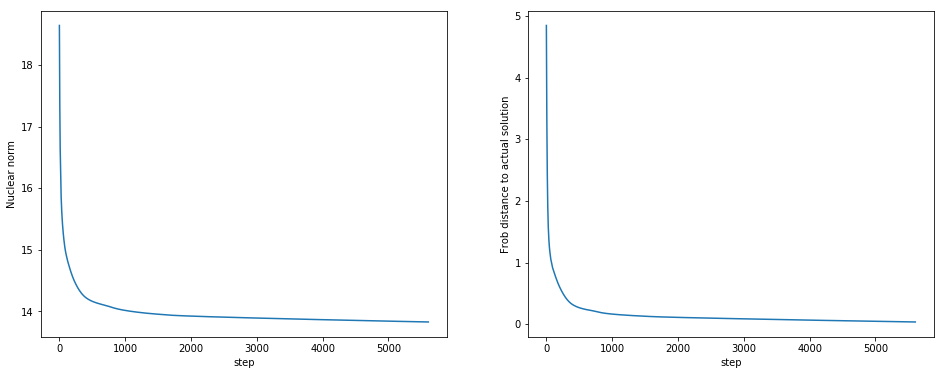

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

ax1.plot(norms)
ax2.plot(distances)

ax1.set_xlabel("step")
ax2.set_xlabel("step")

ax1.set_ylabel("Nuclear norm")
ax2.set_ylabel("Frob distance to actual solution")